In [1]:
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob
import pickle
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.ticker as mticker
from scipy import stats
from statsmodels.nonparametric.kde import KDEUnivariate

Notes from spatial analysis section:

LST histogram, cloud coverage and when maybe, 
One by histogram, each city has a colored line, statistical outliers

All data analysis. General properties of the dataset

In [2]:
dataset_root = '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset'

In [3]:
cities = [
    'Jacksonville', 'DMV', 'NYC', 'Phoenix', 'Miami', 'Chicago', 'Denver', 'Seattle', 'San_Francisco', 'Los_Angeles', 'Atlanta', 'Toronto',
    'Mexico_City', 'Las_Vegas', 'Salt_Lake_City', 'Dallas', 'Houston', 'New_Orleans', 'St_Louis', 'Minneapolis',
    'Charlotte', 'Philadelphia', 'San_Diego', 'San_Juan', 'Montreal', 'Guadalajara', 'Monterrey', 'Cancun', 'Billings', 'Guatemala_City',
    'San_Jose', 'Havana', 'Santo_Domingo', 'Tegucigalpa', 'Managua', 'Panama_City', 'Bogota', 'Lima', 'Quito', 'Santiago', 'Buenos_Aires',
    'Sao_Paulo', 'Manaus', 'Punta_Arenas', 'La_Paz', 'Montevideo', 'Brasilia', 'Caracas'
]
cities = sorted(cities)

In [4]:
def round_to_nearest_10_minutes(dt):
    """
    Rounds a datetime object to the nearest 10 minutes.

    Args:
    dt (datetime object): Datetime to round

    Returns:
    rounded_dt (datetime object): Rounded datetime
    """
    # Calculate the remainder when minutes are divided by 10
    remainder_minutes = dt.minute % 10

    # Determine whether to round up or down
    if remainder_minutes >= 5:
        # Round up: add minutes to reach the next 10-minute interval
        minutes_to_add = 10 - remainder_minutes
        rounded_dt = dt + timedelta(minutes=minutes_to_add)
    else:
        # Round down: subtract minutes to reach the previous 10-minute interval
        minutes_to_subtract = remainder_minutes
        rounded_dt = dt - timedelta(minutes=minutes_to_subtract)

    return rounded_dt

In [5]:
date_dict = {string: [] for string in cities}
date_str_dict = {string: [] for string in cities}
GOES_date_dict = {string: [] for string in cities}

In [6]:
def check_GOES_file_exists(dt):
    """
    Checks if a GOES file exists. Used as a secondary function to round_to_nearest_10_minutes
    to check if the rounded datetime has a corresponding file.

    Args:
    dt (datetime object): Datetime of the GOES file to check for

    Returns:
    exists (boolean): Whether the file exists or not
    """
    dt_str = dt.strftime("%Y%m%d%H%M")
    if dt.year == 2022 and dt.month <= 6:
        file_list = glob.glob(f'{dataset_root}/{city}/GOES_2022_1/*')
        exists = f'{dataset_root}/{city}/GOES_2022_1/GOES_image_{dt_str}.tif' in file_list
    elif dt.year == 2022 and dt.month > 6:
        file_list = glob.glob(f'{dataset_root}/{city}/GOES_2022_2/*')
        exists = f'{dataset_root}/{city}/GOES_2022_2/GOES_image_{dt_str}.tif' in file_list
    elif dt.year == 2023 and dt.month <= 6:
        file_list = glob.glob(f'{dataset_root}/{city}/GOES_2023_1/*')
        exists = f'{dataset_root}/{city}/GOES_2023_1/GOES_image_{dt_str}.tif' in file_list
    else:
        file_list = glob.glob(f'{dataset_root}/{city}/GOES_2023_2/*')
        exists = f'{dataset_root}/{city}/GOES_2023_2/GOES_image_{dt_str}.tif' in file_list

    return exists

In [7]:
format_string = "%Y%m%d%H%M"

for city in cities:
    #print(city)
    city_list = sorted(glob.glob(f'{dataset_root}/{city}/processed_Landsat/*'))
    for file in city_list:
        #print(file)
        dt_str = file.split('_')[-1].split('.')[0]
        dt = datetime.strptime(dt_str, format_string)
        date_dict[city].append(dt)
        date_str_dict[city].append(dt_str[:8])
        rounded_dt = round_to_nearest_10_minutes(dt)
        if check_GOES_file_exists(rounded_dt):  # Only add to list if the time has a GOES file
            GOES_date_dict[city].append(rounded_dt)

## LST

In [16]:
city_data = []

for city in cities:
    print(city)
    city_list = glob.glob(f'{dataset_root}/{city}/processed_Landsat/*')
    for file in city_list:
        data = xr.open_dataset(file)['Landsat_LST'].values
        city_data.append(np.nanmedian(data))

Atlanta
Billings
Bogota
Brasilia
Buenos_Aires
Cancun
Caracas
Charlotte
Chicago
DMV
Dallas
Denver
Guadalajara
Guatemala_City
Havana
Houston
Jacksonville
La_Paz
Las_Vegas
Lima
Los_Angeles
Managua
Manaus
Mexico_City
Miami
Minneapolis
Monterrey
Montevideo
Montreal
NYC
New_Orleans
Panama_City
Philadelphia
Phoenix
Punta_Arenas
Quito
Salt_Lake_City
San_Diego
San_Francisco
San_Jose
San_Juan
Santiago
Santo_Domingo
Sao_Paulo
Seattle
St_Louis
Tegucigalpa
Toronto


In [17]:
# Save median LST data to a pickle
with open('/glade/derecho/scratch/jstarfeldt/data_analysis/all_LSTs.pkl', 'wb') as file:
    pickle.dump(city_data, file)

In [8]:
# Load median LST pickle
with open('/glade/derecho/scratch/jstarfeldt/data_analysis/all_LSTs.pkl', 'rb') as file:
    city_data = pickle.load(file)

In [9]:
# Separates out the median LST data into its respective cities
med_LST_dict = {}
i = 0
for city in cities:
    num = len(date_str_dict[city])
    med_LST_dict[city] = city_data[i:i+num]
    i += num

In [37]:
# Sort the dictionary by the sum of its array values
sorted_data = dict(sorted(med_LST_dict.items(), key=lambda item: np.mean(item[1]), reverse=True))

0
6
12
18
24
30
36
42


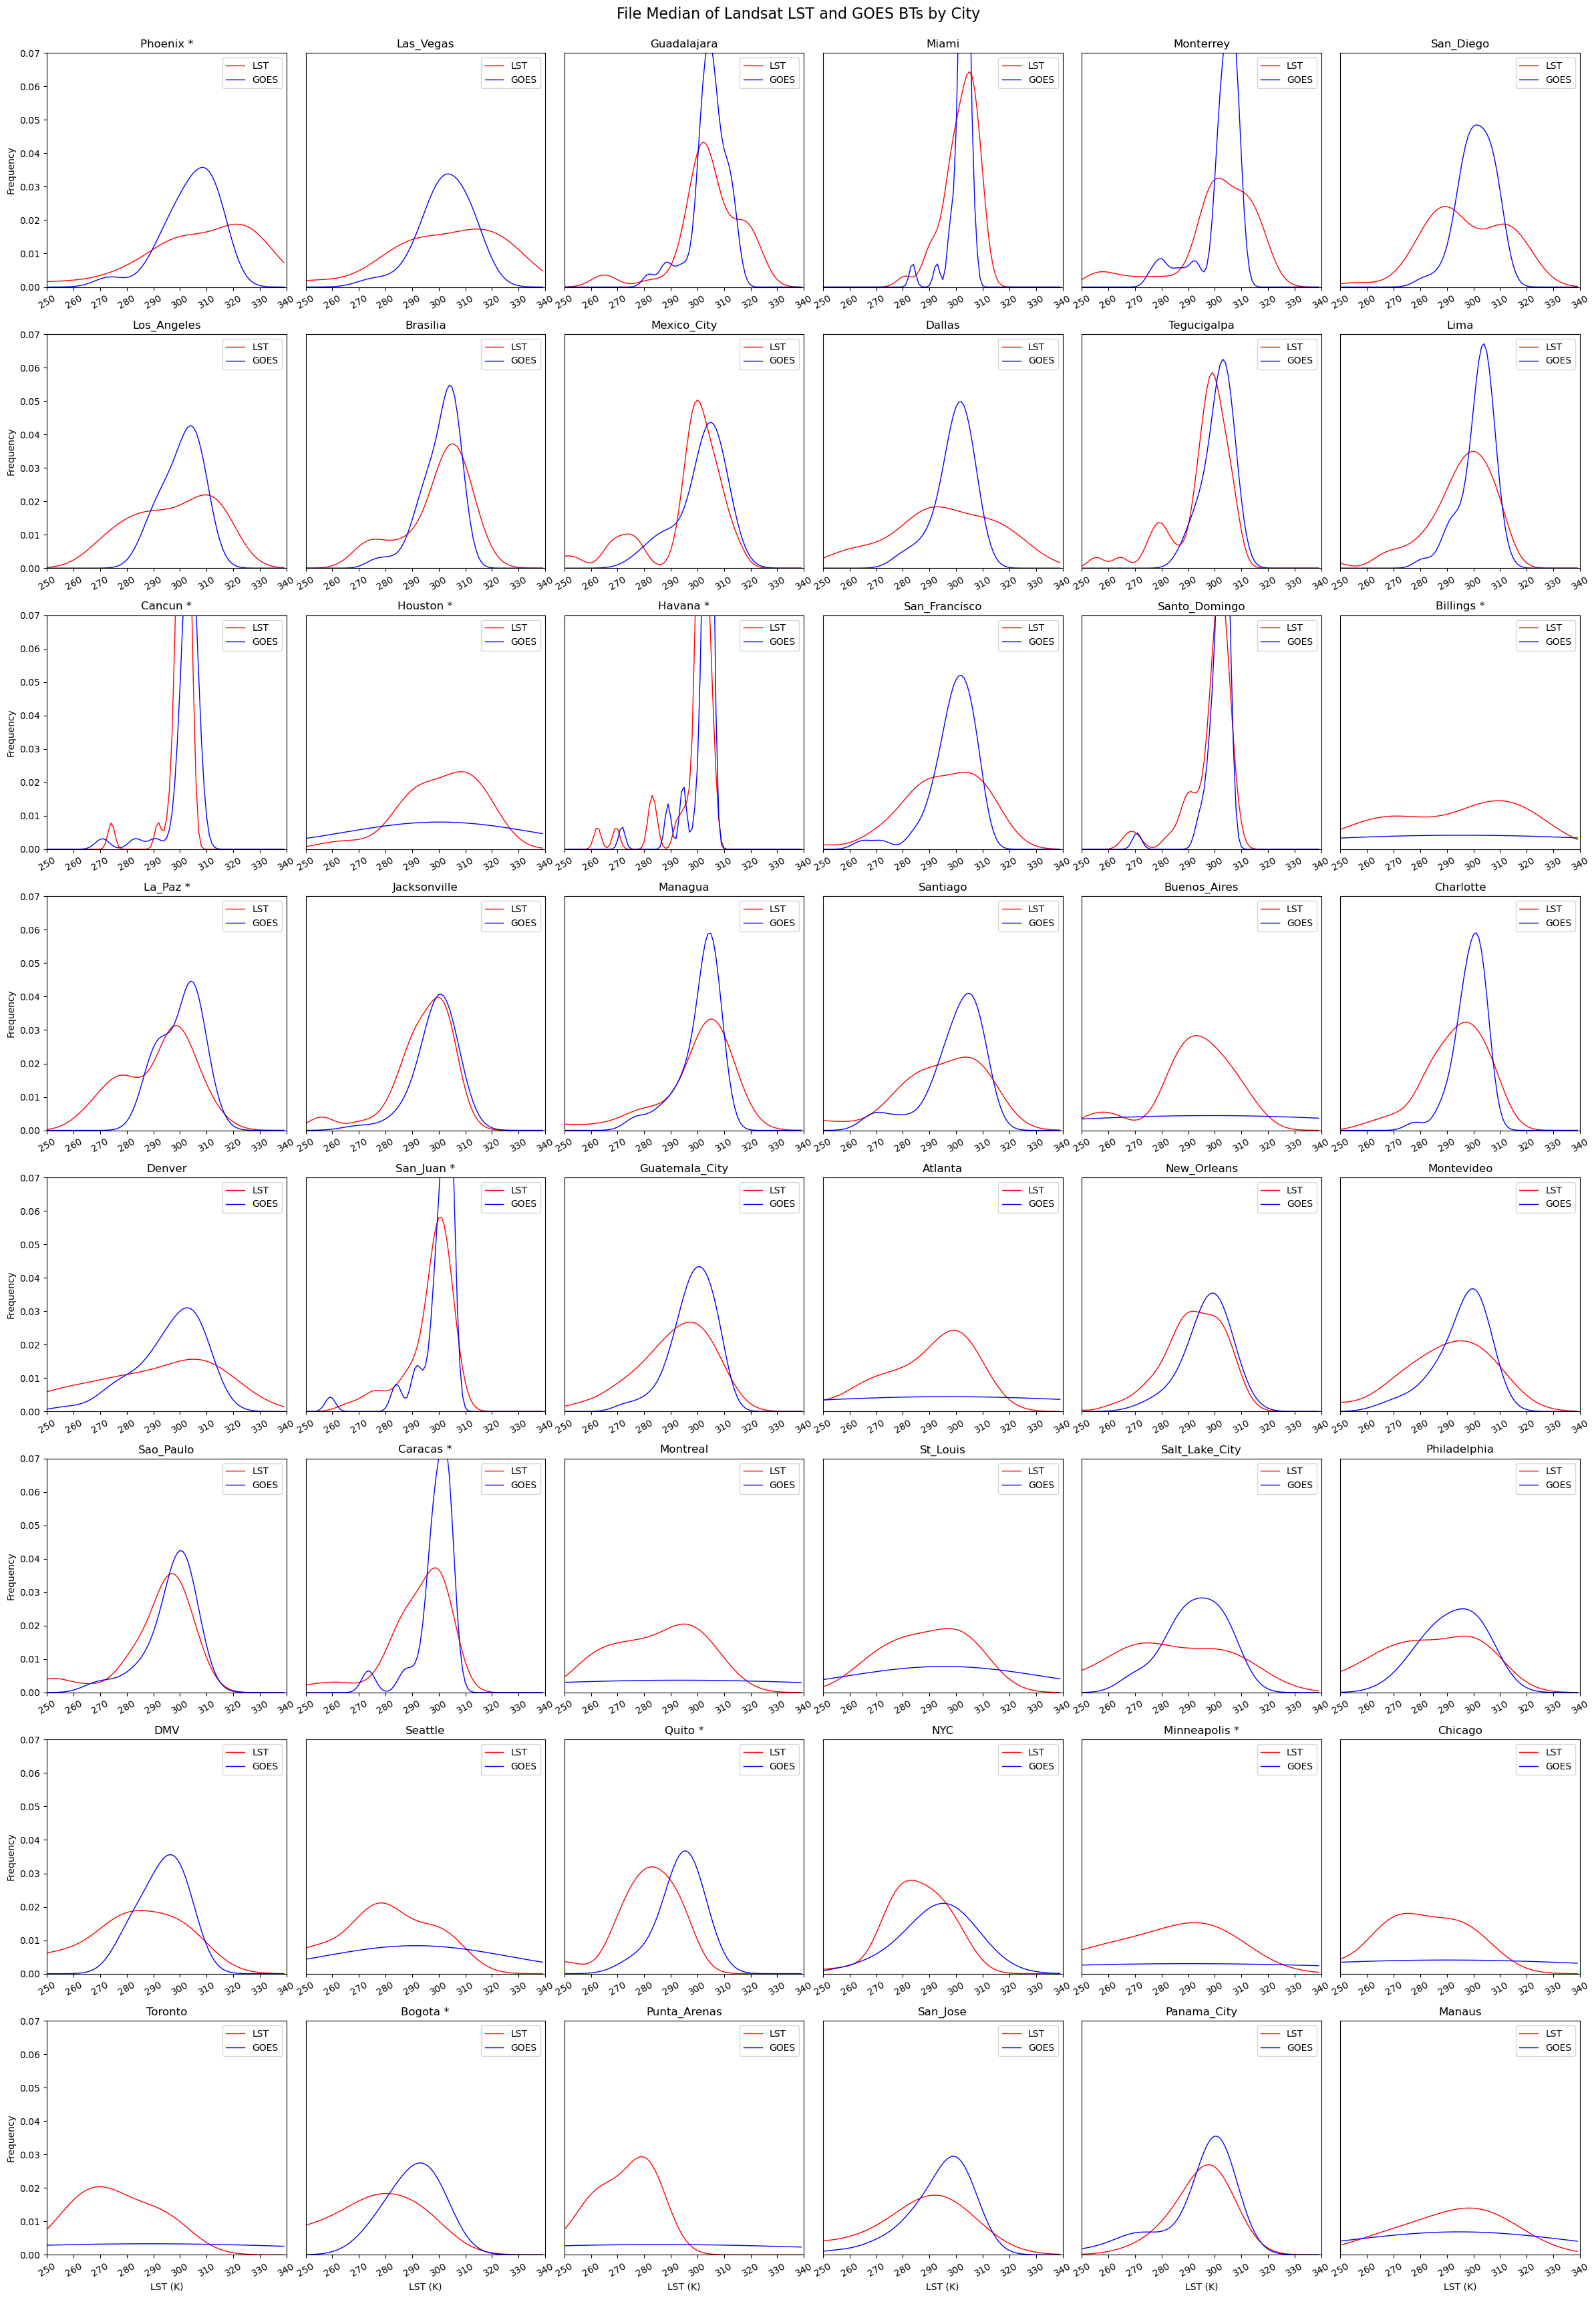

In [39]:
counts, bin_edges = np.histogram(city_data, bins=20)
area = np.sum(counts*(np.nanmax(city_data)-np.nanmin(city_data))/20)
sorted_cities = list(sorted_data.keys())
p_stats = np.zeros(len(cities))

fig, axs = plt.subplots(8, 6)
fig.set_size_inches(24, 34)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.subplots_adjust(hspace=0.3)
colors = cm.jet(np.linspace(0, 1, 48))

#box.plot(date_dict[cities[i]], cloud_dict[cities[i]], color=colors[i])
#box.set_xticks(date_dict[cities[i]][::4], labels=date_str_dict[cities[i]][::4], rotation=45)
#box.set_yticks(np.arange(0,1.01,0.2))
        
i = 0
for row in axs:
    print(i)
    for ax in row:
        city = sorted_cities[i]
        # Create a secondary y-axis sharing the x-axis
        #ax2 = ax.twinx()
        x = np.arange(250, 340)

        # Landsat LST data
        city_list = glob.glob(f'{dataset_root}/{city}/processed_Landsat/*')
        j = 0
        #Landsat_data = np.zeros((len(city_list), 3000, 3000))
        #for file in city_list:
        #    data = xr.open_dataset(file)['Landsat_LST'].values
        #    Landsat_data[j] = data
        #    j += 1
        Landsat_data = sorted_data[city]
        LST_pdf = KDEUnivariate(Landsat_data)
        LST_pdf.fit()
        #Landsat_data = Landsat_data.flatten()
        #LST_mean = np.nanmean(Landsat_data)
        #LST_std = np.nanstd(Landsat_data)
        #LST_pdf = stats.gaussian_kde(Landsat_data)(x)

        # GOES LWIR temperature data
        GOES_data = np.zeros(len(GOES_date_dict))
        j = 0
        for dt in GOES_date_dict[city]:
            dt_str = dt.strftime("%Y%m%d%H%M")
            if dt.year == 2022 and dt.month <= 6:
                data = rxr.open_rasterio(f'{dataset_root}/{city}/GOES_2022_1/GOES_image_{dt_str}.tif')
            elif dt.year == 2022 and dt.month > 6:
                data = rxr.open_rasterio(f'{dataset_root}/{city}/GOES_2022_2/GOES_image_{dt_str}.tif')
            elif dt.year == 2023 and dt.month <= 6:
                data = rxr.open_rasterio(f'{dataset_root}/{city}/GOES_2023_1/GOES_image_{dt_str}.tif')
            else:
                data = rxr.open_rasterio(f'{dataset_root}/{city}/GOES_2023_2/GOES_image_{dt_str}.tif')
            GOES_data[j] = np.nanmedian(data)
            j += 1
        #GOES_data = GOES_data.flatten()
        #GOES_mean = np.nanmean(GOES_data)
        #GOES_std = np.nanstd(GOES_data)
        #GOES_pdf = stats.gaussian_kde(GOES_data, bw_method=5)(x)
        GOES_pdf = KDEUnivariate(GOES_data)
        GOES_pdf.fit()

        # Calculate Mann-Whitney test for equivalence of distribution
        p_value = stats.mannwhitneyu(Landsat_data, GOES_data, nan_policy='omit').pvalue
        p_stats[i] = p_value
        
        # Plot data on the right y-axis
        #ax2.hist(city_data, bins=20, alpha=0.5, color='white', edgecolor='black')
        #ax2.set_yticks([])

        # Plot the PDFs
        ax.plot(x, LST_pdf.evaluate(x), linewidth=1, color='red', label='LST')
        ax.plot(x, GOES_pdf.evaluate(x), linewidth=1, color='b', label='GOES')
        #ax2.axvline(x=LST_mean - 2*LST_std, color='red', linestyle='dashed')
        #ax2.axvline(x=LST_mean + 2*LST_std, color='red', linestyle='dashed')
        #ax2.axvline(x=GOES_mean - 2*GOES_std, color='b', linestyle='dashed')
        #ax2.axvline(x=GOES_mean + 2*GOES_std, color='b', linestyle='dashed')
        ax.legend()
        ax.set_xticks(np.arange(250, 341, 10), labels=np.arange(250, 341, 10), rotation=30)
        #ax2.set_xlim(left=250, right=340)
        #ax2.set_ylim(bottom=0, top=500)
        ax.set_ylim(bottom=0, top=0.07)
        ax.set_xlim(left=250, right=340)
        if i % 6 == 0: # First in row
            ax.set_ylabel('Frequency')
            ax.set_yticks(np.arange(0, 0.075, 0.01))
        else:
            ax.set_yticks([])

        if i >= 42: # Last row
            ax.set_xlabel('LST (K)')

        if p_value < 0.05:
            ax.set_title(city+' *')
        else:
            ax.set_title(city)
        i += 1

plt.tight_layout(w_pad=-0.1)
plt.suptitle('File Median of Landsat LST and GOES BTs by City', y=1.01, fontsize=16)
plt.show()
fig.savefig('/glade/derecho/scratch/jstarfeldt/data_analysis/plots/temps_comparison_histogram.svg', transparent=True, bbox_inches='tight')

In [19]:
# Save stat dict to a pickle
with open('/glade/derecho/scratch/jstarfeldt/data_analysis/temp_comparison_p_stats.pkl', 'wb') as file:
    pickle.dump(p_stats, file)

In [8]:
# Load stat dict pickle
with open('/glade/derecho/scratch/jstarfeldt/data_analysis/temp_comparison_p_stats.pkl', 'rb') as file:
    p_stats = pickle.load(file)

In [8]:
def get_LST_arrs(file_list):
    """
    Takes a list of files and returns all LST values in those files.
    
    args:
    file_list (list of strs): Full file paths of files to pull values from.
    """
    LST_arrs = []
    for file in file_list:
        LST_arrs.append(xr.open_dataset(file)['Landsat_LST'].values)
    return np.stack(LST_arrs)

In [11]:
def get_GOES_temps(city, season_code):
    """
    Returns an array of all GOES temperature data for a certain season out of all GOES files
    that overlap in time with a Landsat file of dimensions (day, band, y, x)

    Args:
    city (str): name of a city from the "cities" array
    season_code (str): One of ['DJF', 'MAM', 'JJA', 'SON'] for December/January/February,
                        March/April/May, June/July/August, or September/October/November
                        
    Returns:
    GOES_data (numpy array): Array of GOES temperature data
    """
    if season_code == 'DJF':
        months = [12, 1, 2]
    elif season_code == 'MAM':
        months = [3, 4, 5]
    elif season_code == 'JJA':
        months = [6, 7, 8]
    else:
        months = [9, 10, 11]
        
    GOES_temp_data = []
    for dt in GOES_date_dict[city]:
        if dt.month in months:
            dt_str = dt.strftime("%Y%m%d%H%M")
            if dt.year == 2022 and dt.month <= 6:
                data = rxr.open_rasterio(f'{dataset_root}/{city}/GOES_2022_1/GOES_image_{dt_str}.tif')
            elif dt.year == 2022 and dt.month > 6:
                data = rxr.open_rasterio(f'{dataset_root}/{city}/GOES_2022_2/GOES_image_{dt_str}.tif')
            elif dt.year == 2023 and dt.month <= 6:
                data = rxr.open_rasterio(f'{dataset_root}/{city}/GOES_2023_1/GOES_image_{dt_str}.tif')
            else:
                data = rxr.open_rasterio(f'{dataset_root}/{city}/GOES_2023_2/GOES_image_{dt_str}.tif')
            GOES_temp_data.append(data.values)
    GOES_data = np.stack(GOES_temp_data)
    return GOES_data

0


/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:17: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:25: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:33: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:41: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:17: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:25: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykerne

1


/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:17: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:25: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:33: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:41: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:17: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:25: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykerne

2


/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:17: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:25: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:33: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:41: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:17: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:25: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykerne

3


/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:17: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:25: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:33: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:41: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:17: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:25: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykerne

4


/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:17: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:25: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:33: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:41: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:17: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:25: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykerne

5


/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:17: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:25: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:33: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:41: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:17: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:25: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykerne

6


/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:25: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:17: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:25: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:33: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:41: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:17: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykerne

7


/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:17: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:25: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:33: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:41: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:17: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_83195/3025524401.py:25: RuntimeWarning: All-NaN slice encountered
  arr = np.nanmedian(data, axis=0).flatten()
/glade/derecho/scratch/jstarfeldt/tmp/ipykerne

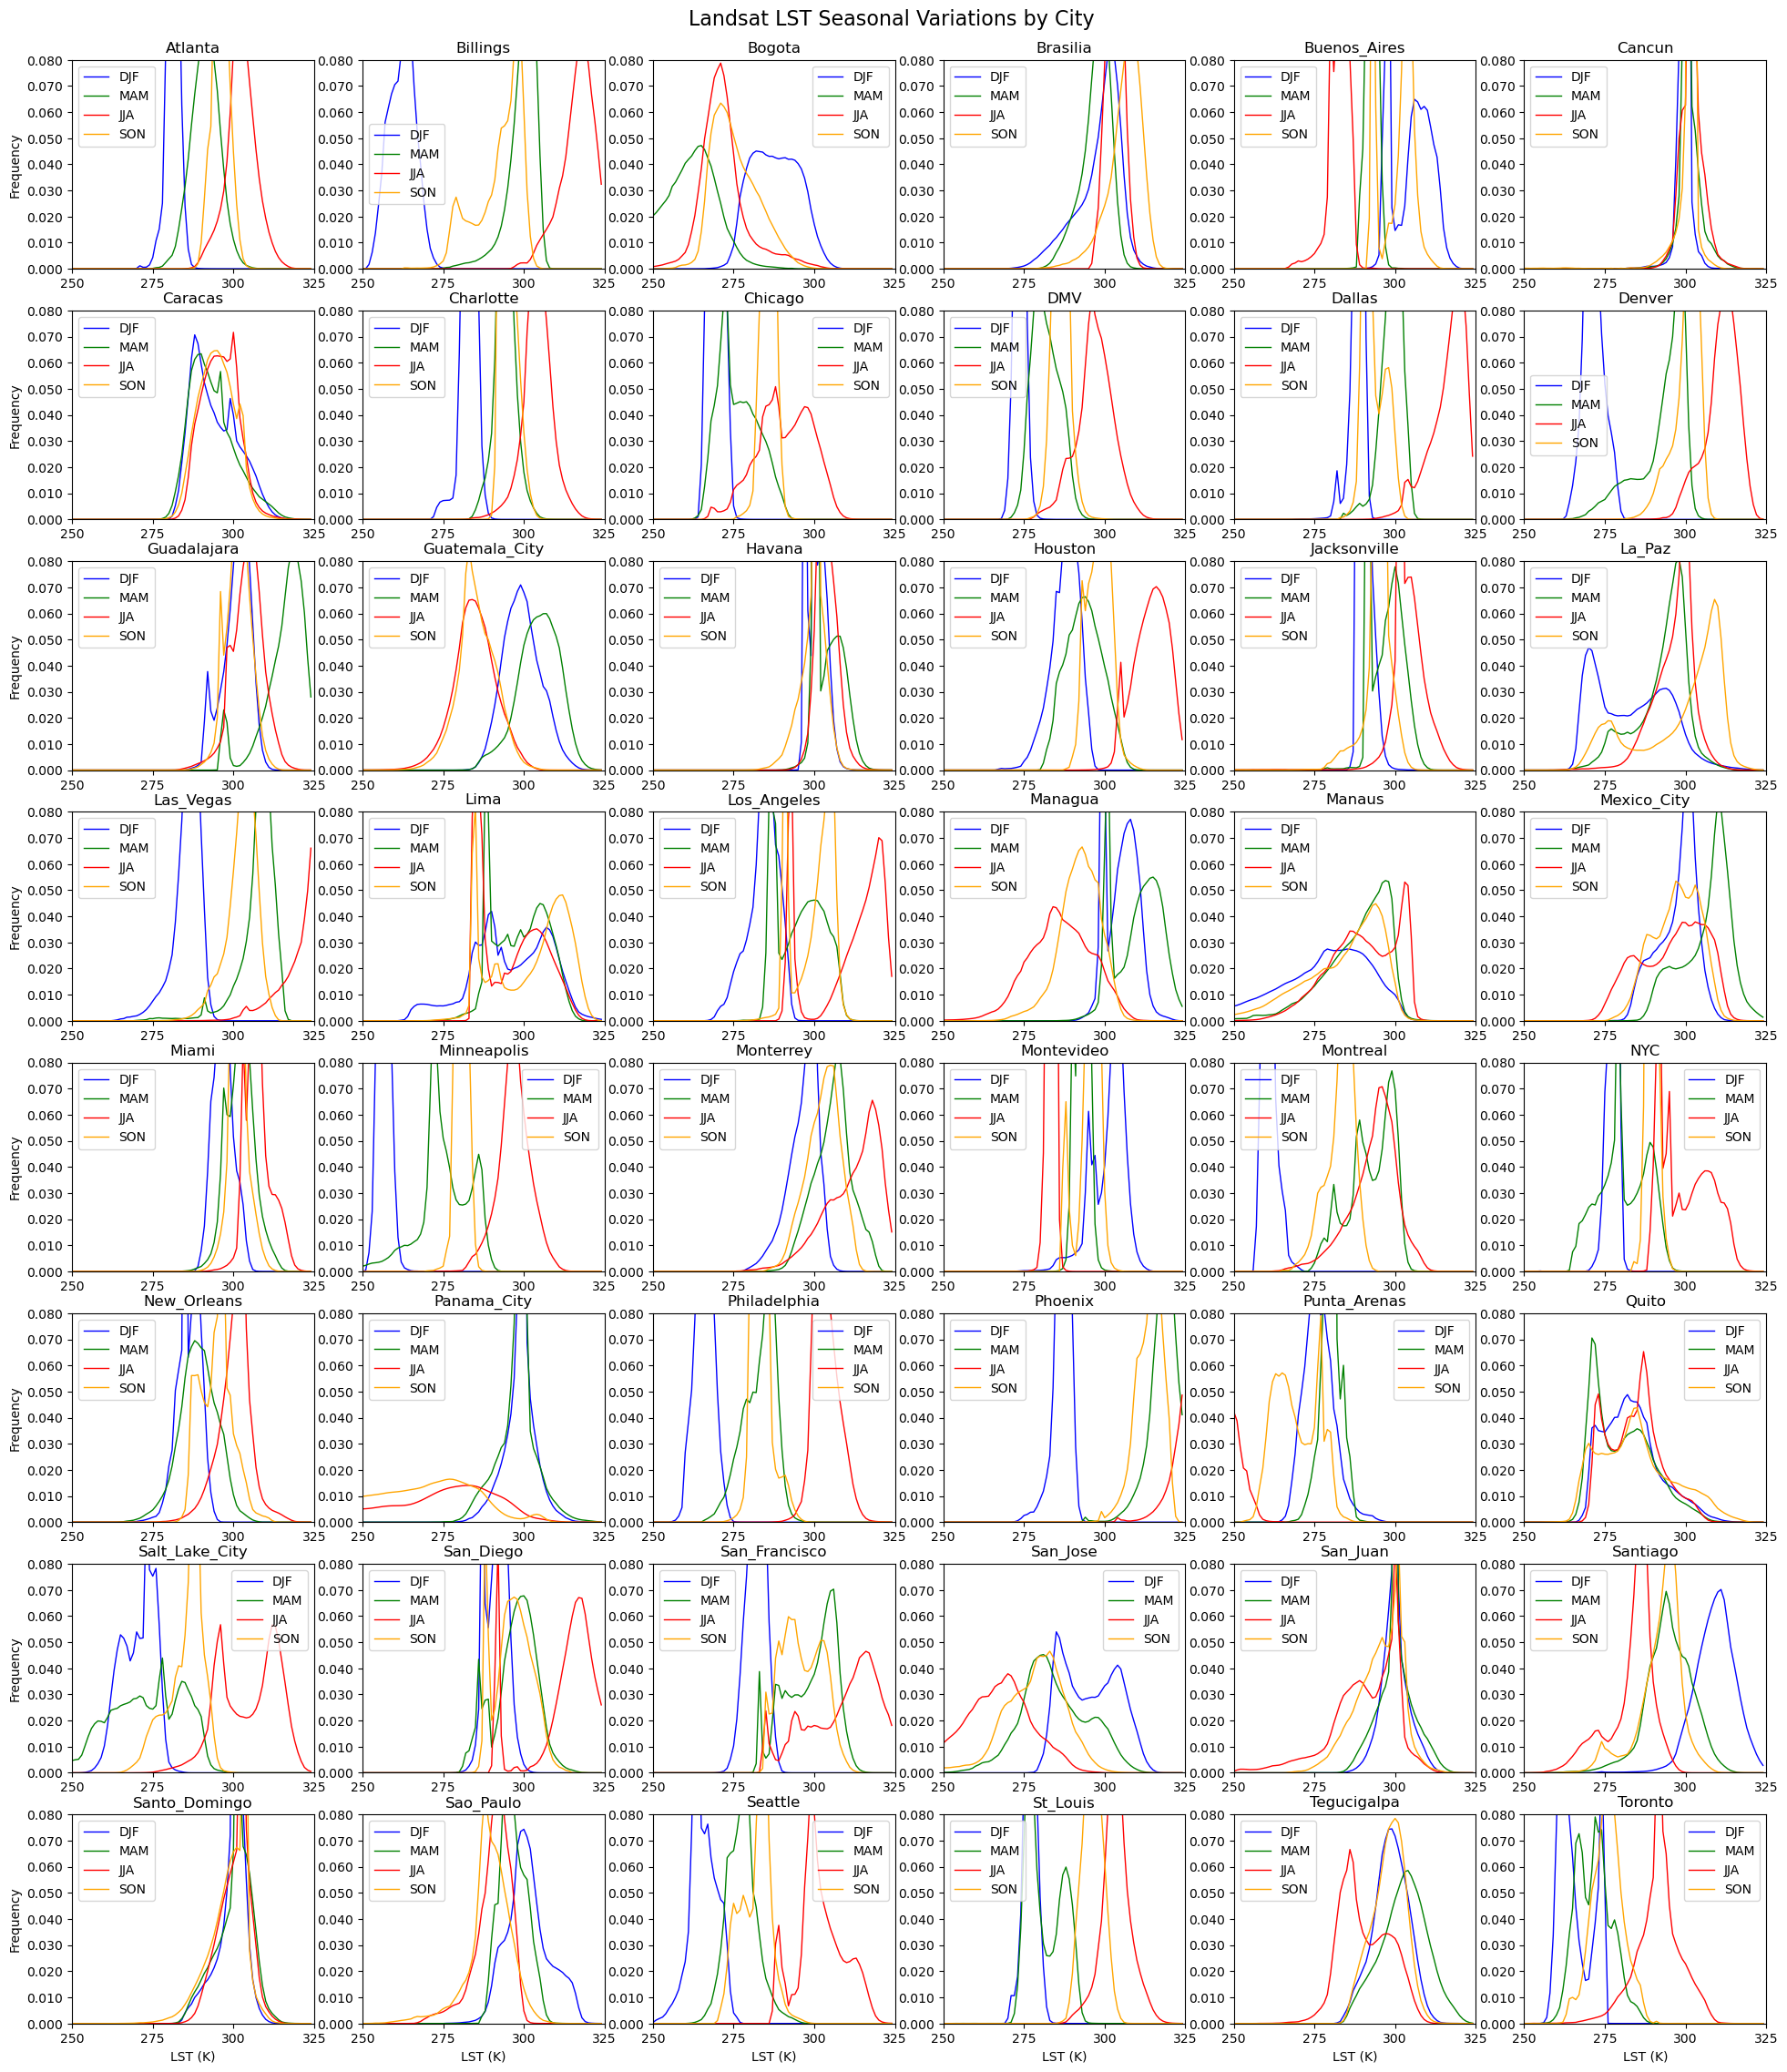

In [9]:
fig, axs = plt.subplots(8, 6)
fig.set_size_inches(24, 28)
#plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.subplots_adjust(hspace=0.2)
x = np.arange(250, 325)

for i in range(8):
    print(i)
    for j in range(6):
        city = cities[i*6+j]
        city_list = np.array(sorted(glob.glob(f'{dataset_root}/{city}/processed_Landsat/*')))
        month_list = np.array([dt.month for dt in date_dict[city]])
        #LST_list = np.array(med_LST_dict[city])

        DJF_indices = np.where(np.logical_or(month_list==12, month_list<3))
        data = get_LST_arrs(city_list[DJF_indices])
        arr = np.nanmedian(data, axis=0).flatten()
        pdf = KDEUnivariate(arr[~np.isnan(arr)])
        pdf.fit()
        axs[i, j].plot(x, pdf.evaluate(x), color='b', linewidth=1, label='DJF')
        #print('done with first kde')

        MAM_indices = np.where(np.logical_and(month_list>=3, month_list<6))
        data = get_LST_arrs(city_list[MAM_indices])
        arr = np.nanmedian(data, axis=0).flatten()
        pdf = KDEUnivariate(arr[~np.isnan(arr)])
        pdf.fit()
        axs[i, j].plot(x, pdf.evaluate(x), color='g', linewidth=1, label='MAM')
        #print('done with second kde')

        JJA_indices = np.where(np.logical_and(month_list>=6, month_list<9))
        data = get_LST_arrs(city_list[JJA_indices])
        arr = np.nanmedian(data, axis=0).flatten()
        pdf = KDEUnivariate(arr[~np.isnan(arr)])
        pdf.fit()
        axs[i, j].plot(x, pdf.evaluate(x), color='r', linewidth=1, label='JJA')
        #print('done with third kde')

        SON_indices = np.where(np.logical_and(month_list>=9, month_list<12))
        data = get_LST_arrs(city_list[SON_indices])
        arr = np.nanmedian(data, axis=0).flatten()
        pdf = KDEUnivariate(arr[~np.isnan(arr)])
        pdf.fit()
        axs[i, j].plot(x, pdf.evaluate(x), color='orange', linewidth=1, label='SON')
        #print('done with fourth kde')

        axs[i, j].legend()
        axs[i, j].set_title(city)
        #print('plotted')

        # Format y-axis ticks to 3 decimal places
        formatter_y = mticker.StrMethodFormatter("{x:.3f}")
        axs[i, j].yaxis.set_major_formatter(formatter_y)
        axs[i, j].set_xlim(left=250, right=325)
        axs[i, j].set_xticks(np.arange(250, 326, 25))
        axs[i, j].set_ylim(bottom=0, top=0.08)
        axs[i, j].set_yticks(np.arange(0, 0.081, 0.01))

        if j == 0:
            axs[i, j].set_ylabel('Frequency')
        if i == 7:
            axs[i, j].set_xlabel('LST (K)')
            
plt.suptitle('Landsat LST Seasonal Variations by City', y=0.9, fontsize=16)
fig.savefig('/glade/derecho/scratch/jstarfeldt/data_analysis/plots/LST_seasonal_variation.svg', transparent=True, bbox_inches='tight')

0
1
2
3
4
5
6
7


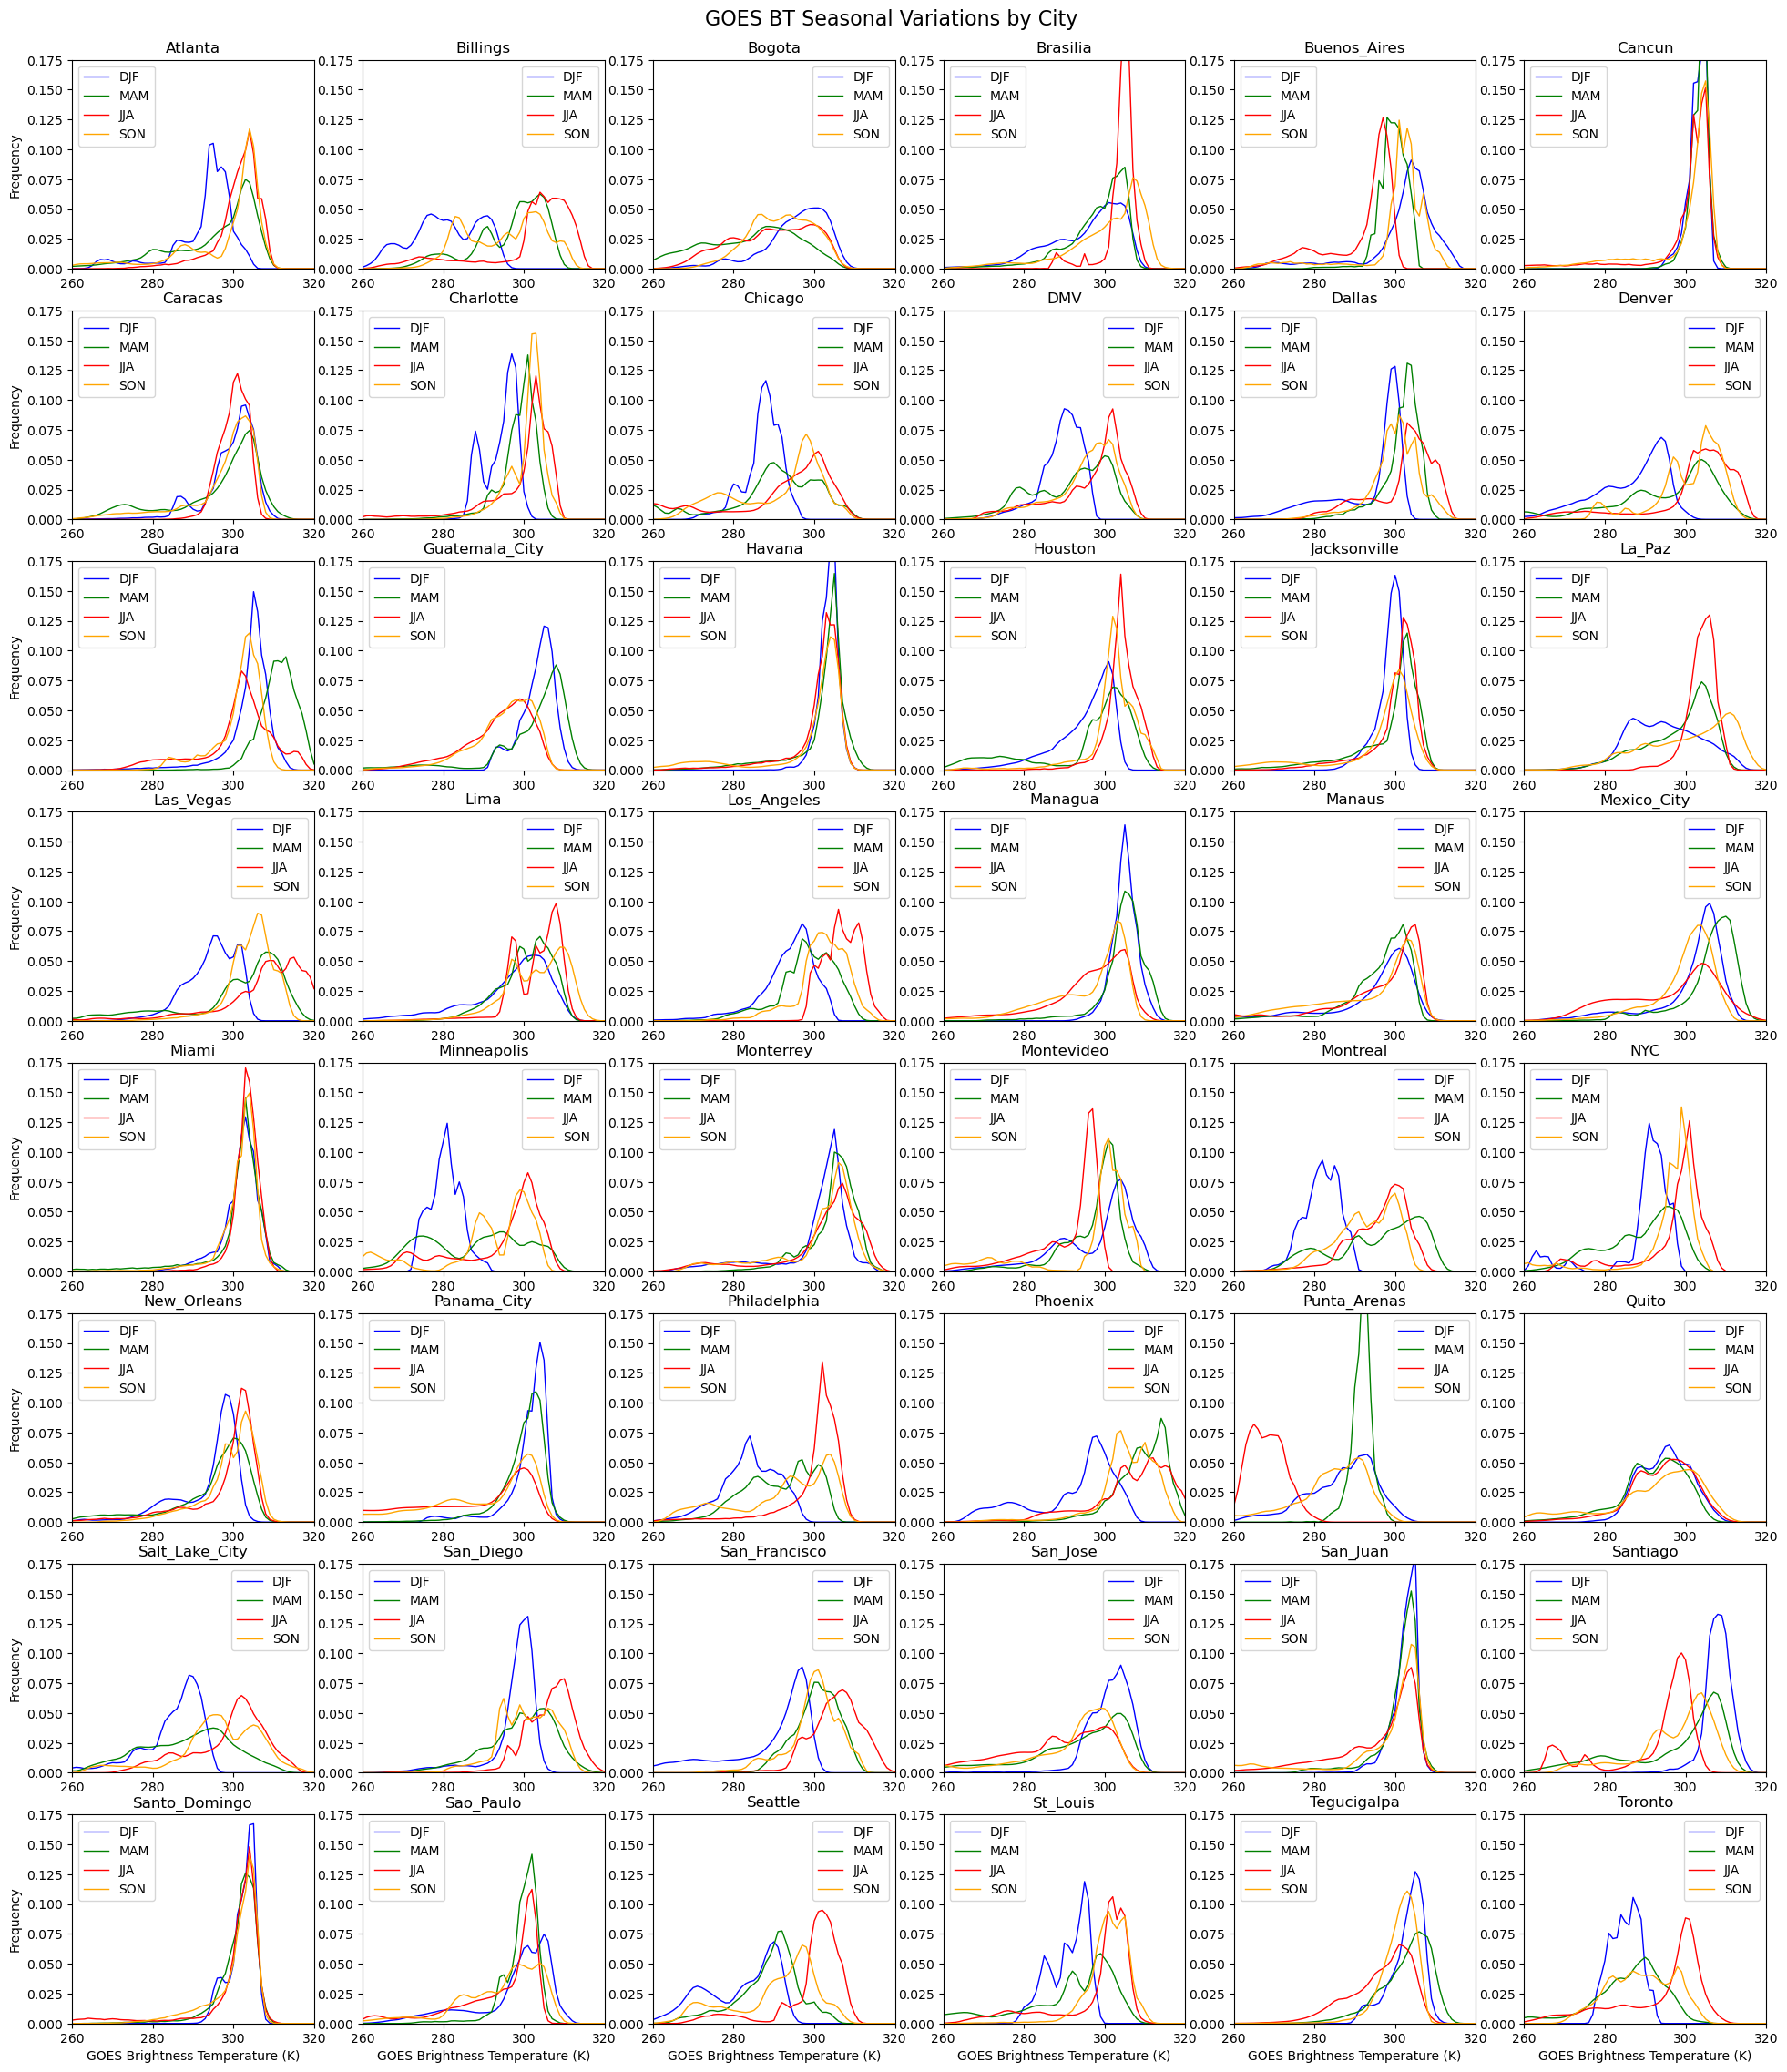

In [15]:
fig, axs = plt.subplots(8, 6)
fig.set_size_inches(24, 28)
#plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.subplots_adjust(hspace=0.2)
x = np.arange(260, 321)

for i in range(8):
    print(i)
    for j in range(6):
        city = cities[i*6+j]

        data = get_GOES_temps(city, 'DJF')
        DJF_pdf = KDEUnivariate(data.flatten())
        DJF_pdf.fit()

        data = get_GOES_temps(city, 'MAM')
        MAM_pdf = KDEUnivariate(data.flatten())
        MAM_pdf.fit()

        data = get_GOES_temps(city, 'JJA')
        JJA_pdf = KDEUnivariate(data.flatten())
        JJA_pdf.fit()

        data = get_GOES_temps(city, 'SON')
        SON_pdf = KDEUnivariate(data.flatten())
        SON_pdf.fit()

        axs[i, j].plot(x, DJF_pdf.evaluate(x), color='b', linewidth=1, label='DJF')
        axs[i, j].plot(x, MAM_pdf.evaluate(x), color='g', linewidth=1, label='MAM')
        axs[i, j].plot(x, JJA_pdf.evaluate(x), color='r', linewidth=1, label='JJA')
        axs[i, j].plot(x, SON_pdf.evaluate(x), color='orange', linewidth=1, label='SON')
        axs[i, j].legend()
        axs[i, j].set_title(city)

        # Format y-axis ticks to 3 decimal places
        formatter_y = mticker.StrMethodFormatter("{x:.3f}")
        axs[i, j].yaxis.set_major_formatter(formatter_y)
        axs[i, j].set_xlim(left=260, right=320)
        axs[i, j].set_xticks(np.arange(260, 321, 20))
        axs[i, j].set_ylim(bottom=0, top=0.175)
        axs[i, j].set_yticks(np.arange(0, 0.176, 0.025))

        if j == 0:
            axs[i, j].set_ylabel('Frequency')
        if i == 7:
            axs[i,j].set_xlabel('GOES Brightness Temperature (K)')

plt.suptitle('GOES BT Seasonal Variations by City', y=0.9, fontsize=16)
fig.savefig('/glade/derecho/scratch/jstarfeldt/data_analysis/plots/GOES_BT_seasonal_variation.svg', transparent=True, bbox_inches='tight')

## Cloud fraction

In [22]:
def index(val):
    """
    Extracts the "cloud" bit value from a Landsat cloud mask bit string.

    Args:
    val: Pixel value from Landsat cloud mask

    Returns:
    True if the cloud pixel is 1, otherwise False
    """
    try:
        return (str(int(val))[-4] == '1')
    except:
        return False

# Vectorize index function
func = np.vectorize(index)

In [19]:
mask = func(cloud)
mask

/glade/u/home/jstarfeldt/.conda/envs/heat/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2625: RuntimeWarning: invalid value encountered in index (vectorized)
  outputs = ufunc(*args, out=...)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ..., False,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]],
      shape=(3000, 3000))

In [9]:
cloud_dict = {string: [] for string in cities}
cloud_dict

{'Atlanta': [],
 'Billings': [],
 'Bogota': [],
 'Brasilia': [],
 'Buenos_Aires': [],
 'Cancun': [],
 'Caracas': [],
 'Charlotte': [],
 'Chicago': [],
 'DMV': [],
 'Dallas': [],
 'Denver': [],
 'Guadalajara': [],
 'Guatemala_City': [],
 'Havana': [],
 'Houston': [],
 'Jacksonville': [],
 'La_Paz': [],
 'Las_Vegas': [],
 'Lima': [],
 'Los_Angeles': [],
 'Managua': [],
 'Manaus': [],
 'Mexico_City': [],
 'Miami': [],
 'Minneapolis': [],
 'Monterrey': [],
 'Montevideo': [],
 'Montreal': [],
 'NYC': [],
 'New_Orleans': [],
 'Panama_City': [],
 'Philadelphia': [],
 'Phoenix': [],
 'Punta_Arenas': [],
 'Quito': [],
 'Salt_Lake_City': [],
 'San_Diego': [],
 'San_Francisco': [],
 'San_Jose': [],
 'San_Juan': [],
 'Santiago': [],
 'Santo_Domingo': [],
 'Sao_Paulo': [],
 'Seattle': [],
 'St_Louis': [],
 'Tegucigalpa': [],
 'Toronto': []}

In [11]:
for city in cities:
    print(city)
    city_list = glob.glob(f'{dataset_root}/{city}/processed_Landsat/*')
    for file in city_list:
        #print(file)
        data = xr.open_dataset(file)['Landsat_cloud_mask'].values
        pixels = np.sum(np.where(np.nan_to_num(data) == 0, 0, 1))
        cloud = func(data)
        cloud_frac = np.sum(cloud)/pixels
        #city_data.append(cloud_frac)
        cloud_dict[city].append(cloud_frac)

city_data = sum(cloud_dict.values(), [])

Atlanta
Billings
Bogota
Brasilia
Buenos_Aires
Cancun
Caracas
Charlotte
Chicago
DMV
Dallas
Denver
Guadalajara
Guatemala_City
Havana
Houston
Jacksonville
La_Paz
Las_Vegas
Lima
Los_Angeles
Managua
Manaus
Mexico_City
Miami
Minneapolis
Monterrey
Montevideo
Montreal
NYC
New_Orleans
Panama_City
Philadelphia
Phoenix
Punta_Arenas
Quito
Salt_Lake_City
San_Diego
San_Francisco
San_Jose
San_Juan
Santiago
Santo_Domingo
Sao_Paulo
Seattle
St_Louis
Tegucigalpa
Toronto


In [12]:
with open('/glade/derecho/scratch/jstarfeldt/data_analysis/all_cloud_fracs.pkl', 'wb') as file:
    pickle.dump(city_data, file)
with open('/glade/derecho/scratch/jstarfeldt/data_analysis/all_cloud_dicts.pkl', 'wb') as file:
    pickle.dump(cloud_dict, file)

In [23]:
with open('/glade/derecho/scratch/jstarfeldt/data_analysis/all_cloud_fracs.pkl', 'rb') as file:
    city_data = pickle.load(file)
with open('/glade/derecho/scratch/jstarfeldt/data_analysis/all_cloud_dicts.pkl', 'rb') as file:
    cloud_dict = pickle.load(file)

In [24]:
# Sort the dictionary by the sum of its array values
sorted_data = dict(sorted(cloud_dict.items(), key=lambda item: np.mean(item[1]), reverse=True))

In [12]:
sorted_data.keys()

dict_keys(['Bogota', 'Quito', 'San_Jose', 'Panama_City', 'Punta_Arenas', 'Manaus', 'Caracas', 'Toronto', 'Chicago', 'Philadelphia', 'Seattle', 'Guatemala_City', 'Minneapolis', 'DMV', 'Sao_Paulo', 'New_Orleans', 'San_Juan', 'Santo_Domingo', 'Atlanta', 'Tegucigalpa', 'Managua', 'Montevideo', 'Montreal', 'Lima', 'Salt_Lake_City', 'Jacksonville', 'La_Paz', 'Houston', 'NYC', 'Dallas', 'Monterrey', 'Miami', 'St_Louis', 'Los_Angeles', 'Mexico_City', 'Brasilia', 'San_Francisco', 'Havana', 'San_Diego', 'Billings', 'Cancun', 'Buenos_Aires', 'Denver', 'Santiago', 'Charlotte', 'Las_Vegas', 'Phoenix', 'Guadalajara'])

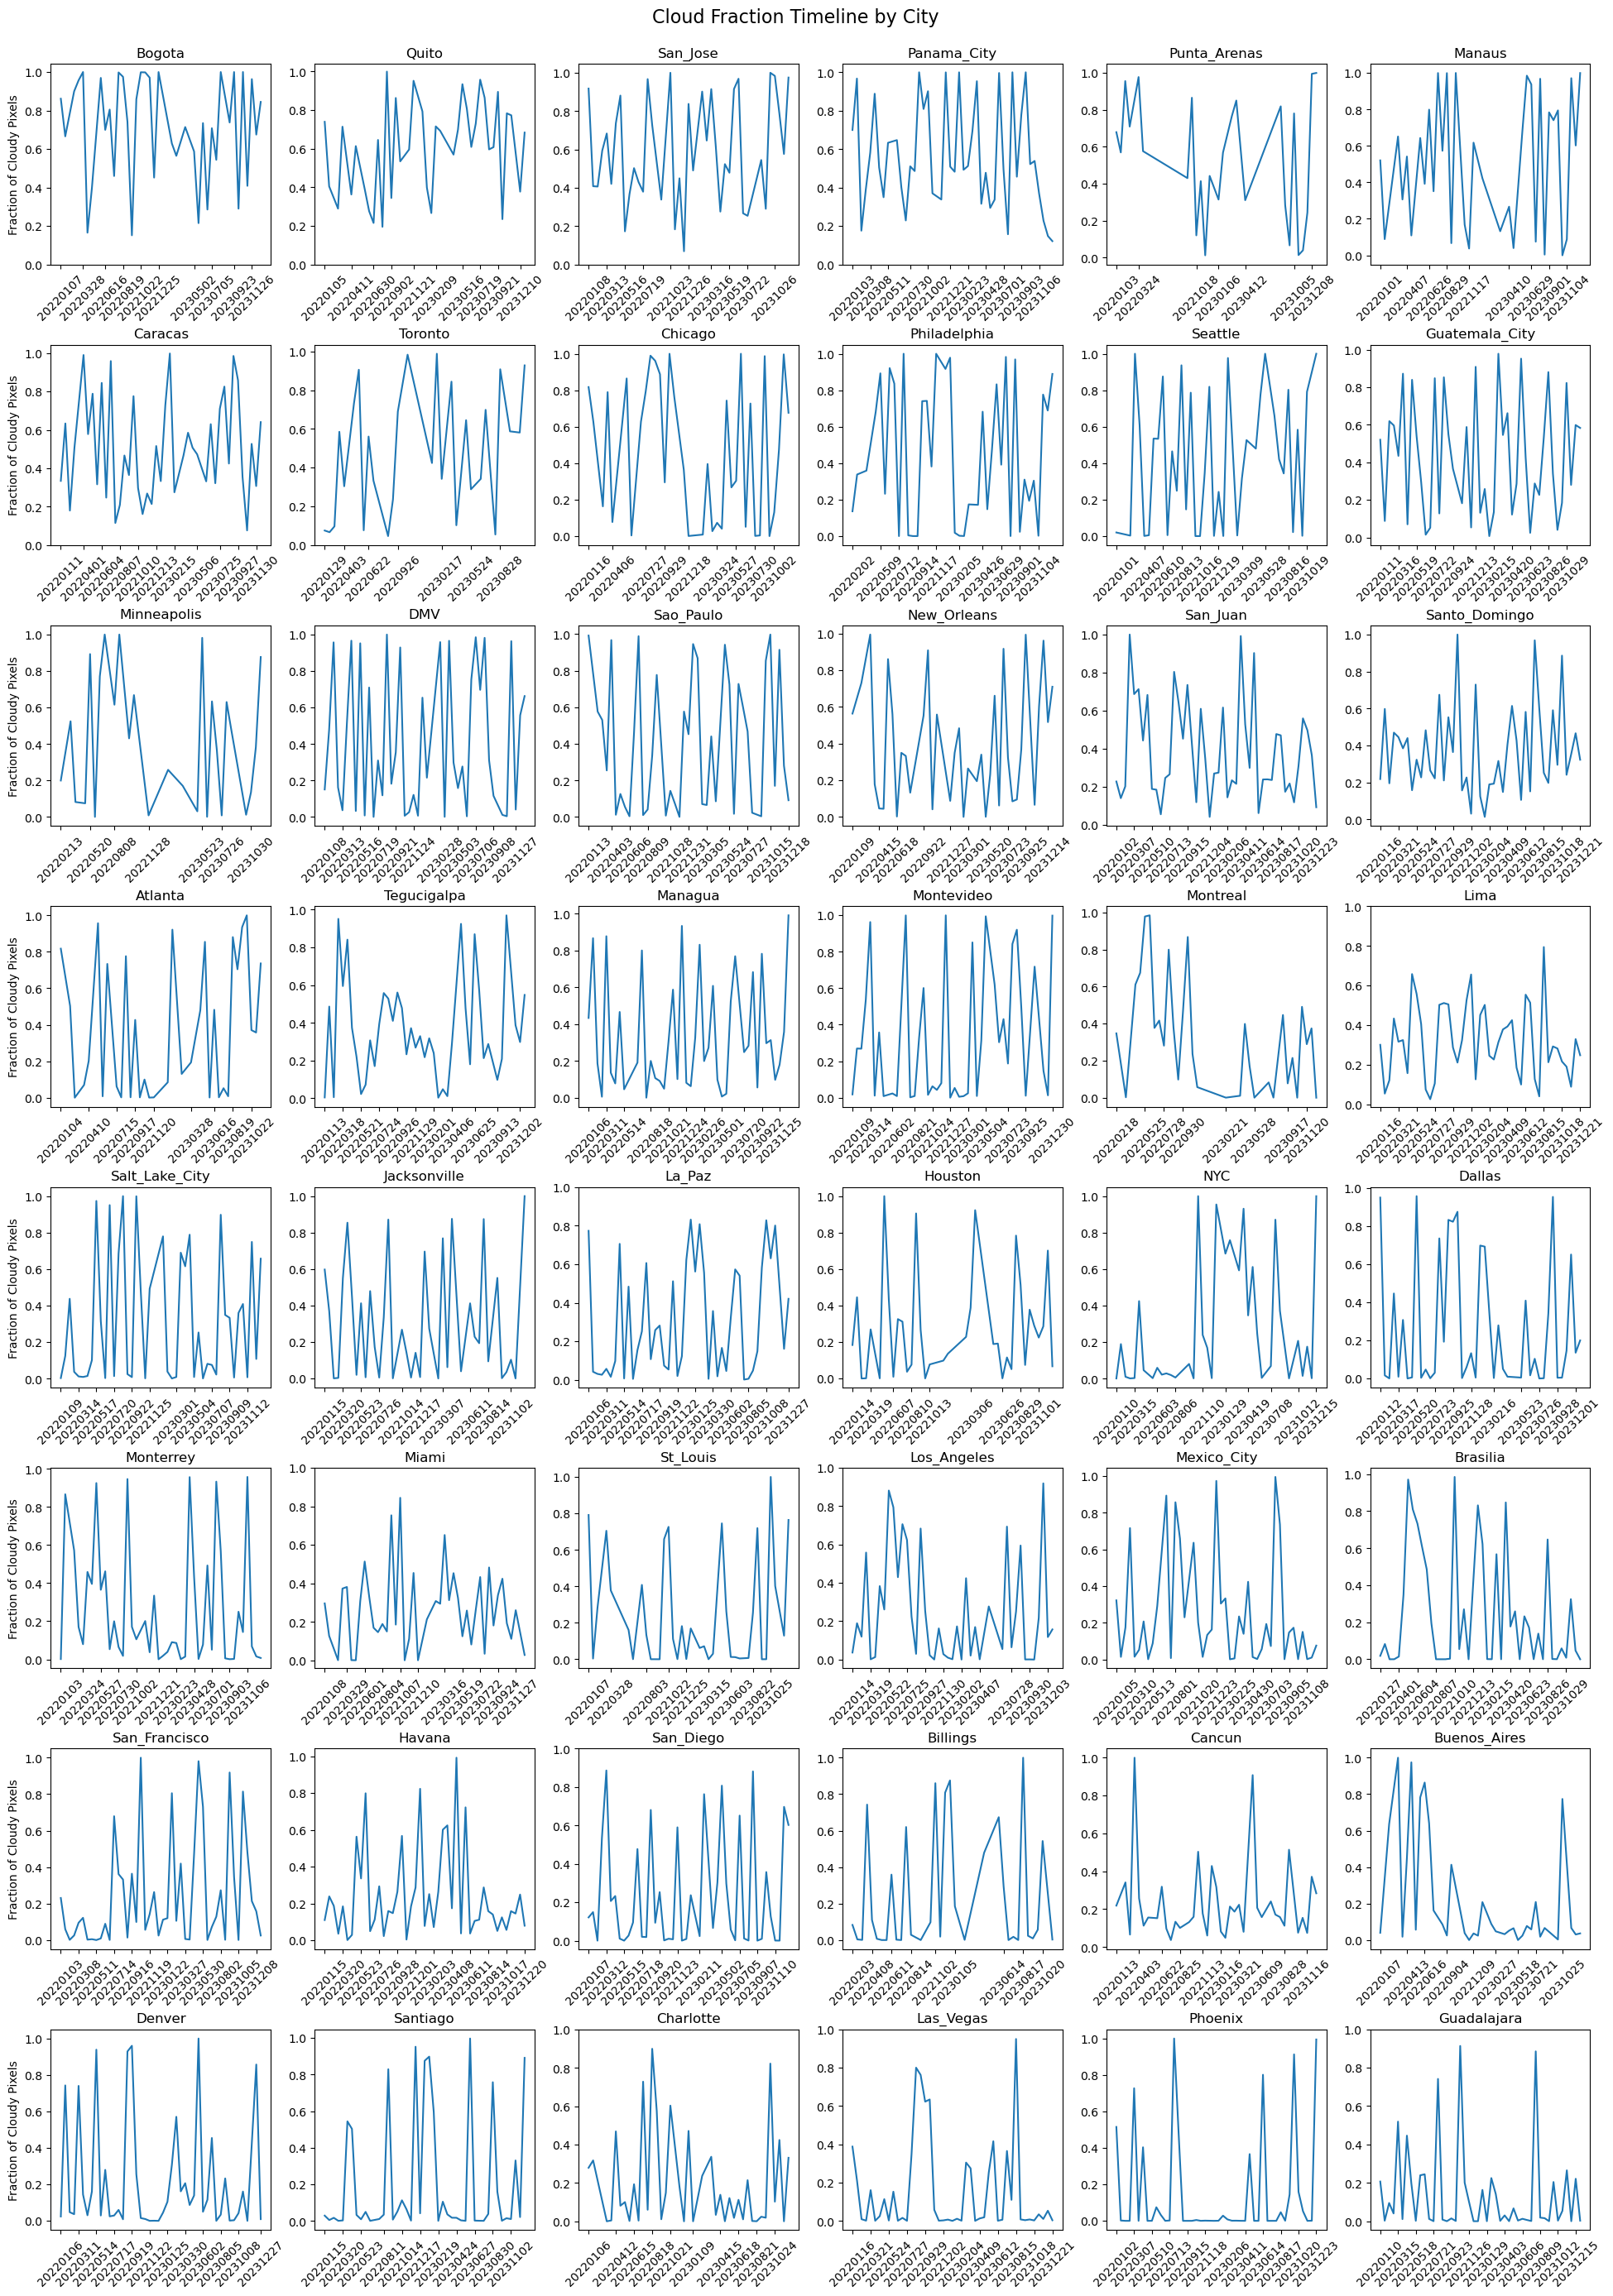

In [25]:
fig, axs = plt.subplots(8, 6)
fig.set_size_inches(24, 34)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.subplots_adjust(hspace=0.4)
colors = cm.jet(np.linspace(0, 1, 48))
sorted_cities = list(sorted_data.keys())

i = 0
for ax in axs:
    for box in ax:
        city = sorted_cities[i]
        box.plot(date_dict[city], cloud_dict[city])
        box.set_xticks(date_dict[city][::4], labels=date_str_dict[city][::4], rotation=45)
        box.set_yticks(np.arange(0,1.01,0.2))
        box.set_title(city)
        if i % 6 == 0:
            box.set_ylabel('Fraction of Cloudy Pixels')
        i += 1
plt.suptitle('Cloud Fraction Timeline by City', y=0.9, fontsize=16)
fig.savefig('/glade/derecho/scratch/jstarfeldt/data_analysis/plots/cloud_fraction_timelines.svg', transparent=True, bbox_inches='tight')

## Variable Correlation

In [9]:
def calculate_corr_matrix(file):
    ds = xr.open_dataset(file)
    arr = ds[['Landsat_blue_reflectance', 'Landsat_green_reflectance', 'Landsat_red_reflectance', 'Landsat_NIR_reflectance',
          'Landsat_SWIR1_reflectance', 'Landsat_SWIR2_reflectance', 'Landsat_LST', 'Sentinel1_VV', 'Sentinel1_VH']]\
        .to_dataarray().values.reshape((9,-1))

    nan_columns = np.isnan(arr).any(axis=0) # Identify columns with NaNs
    filtered_array = arr[:, ~nan_columns] # Filter out columns with NaN

    return np.corrcoef(filtered_array)

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for city in cities:
        corr_matrices = []
        city_list = sorted(glob.glob(f'{dataset_root}/{city}/processed_Landsat/*'))
        
        for file in city_list:
            corr_matrices.append(calculate_corr_matrix(file))
    
        corr_matrix = np.nanmean(corr_matrices, axis=0)
        with open(f'/glade/derecho/scratch/jstarfeldt/data_analysis/corr_matrices/{city}_corr_matrix.pkl', 'wb') as file:
            pickle.dump(corr_matrix, file)

In [29]:
city = 'Los_Angeles'
with open(f'/glade/derecho/scratch/jstarfeldt/data_analysis/corr_matrices/{city}_corr_matrix.pkl', 'rb') as file:
    corr_matrix = pickle.load(file)

In [30]:
corr_matrix

array([[ 1.        ,  0.98584193,  0.97676374,  0.79989938,  0.7818191 ,
         0.79439313, -0.10144477,  0.17310368,  0.15592819],
       [ 0.98584193,  1.        ,  0.9950603 ,  0.84580288,  0.83176528,
         0.84086726, -0.06264791,  0.22071334,  0.20608908],
       [ 0.97676374,  0.9950603 ,  1.        ,  0.85316629,  0.85659472,
         0.86614074, -0.037152  ,  0.24159779,  0.2262172 ],
       [ 0.79989938,  0.84580288,  0.85316629,  1.        ,  0.89430146,
         0.82833616,  0.03160871,  0.36750355,  0.39890867],
       [ 0.7818191 ,  0.83176528,  0.85659472,  0.89430146,  1.        ,
         0.9719385 ,  0.08758115,  0.31919481,  0.32574049],
       [ 0.79439313,  0.84086726,  0.86614074,  0.82833616,  0.9719385 ,
         1.        ,  0.05219406,  0.27795334,  0.27004563],
       [-0.10144477, -0.06264791, -0.037152  ,  0.03160871,  0.08758115,
         0.05219406,  1.        ,  0.46097113,  0.4477092 ],
       [ 0.17310368,  0.22071334,  0.24159779,  0.36750355,  0

In [11]:
vars = ['Blue_reflectance', 'Green_reflectance', 'Red_reflectance', 'NIR_reflectance', 'SWIR1_reflectance', 'SWIR2_reflectance',
       'LST', 'SAR_VV', 'SAR_VH']

Text(0.5, 1.0, 'Los_Angeles Feature Correlations')

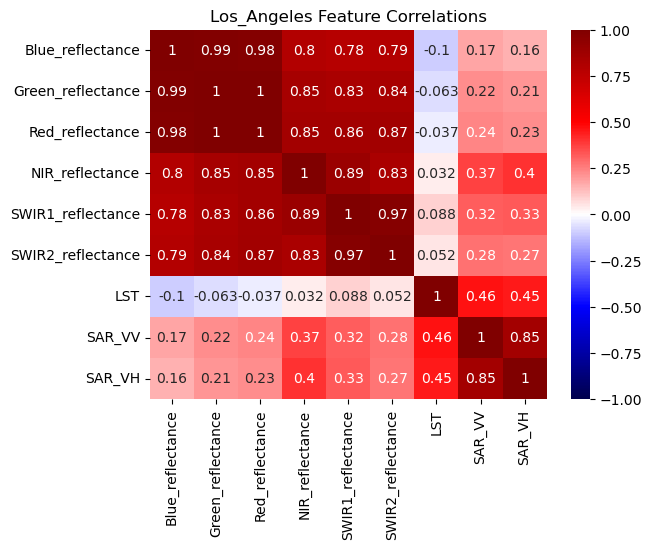

In [35]:
sns.heatmap(corr_matrix, xticklabels=vars, yticklabels=vars, annot=True, cmap='seismic', vmin=-1, vmax=1)
plt.title(f'{city} Feature Correlations')

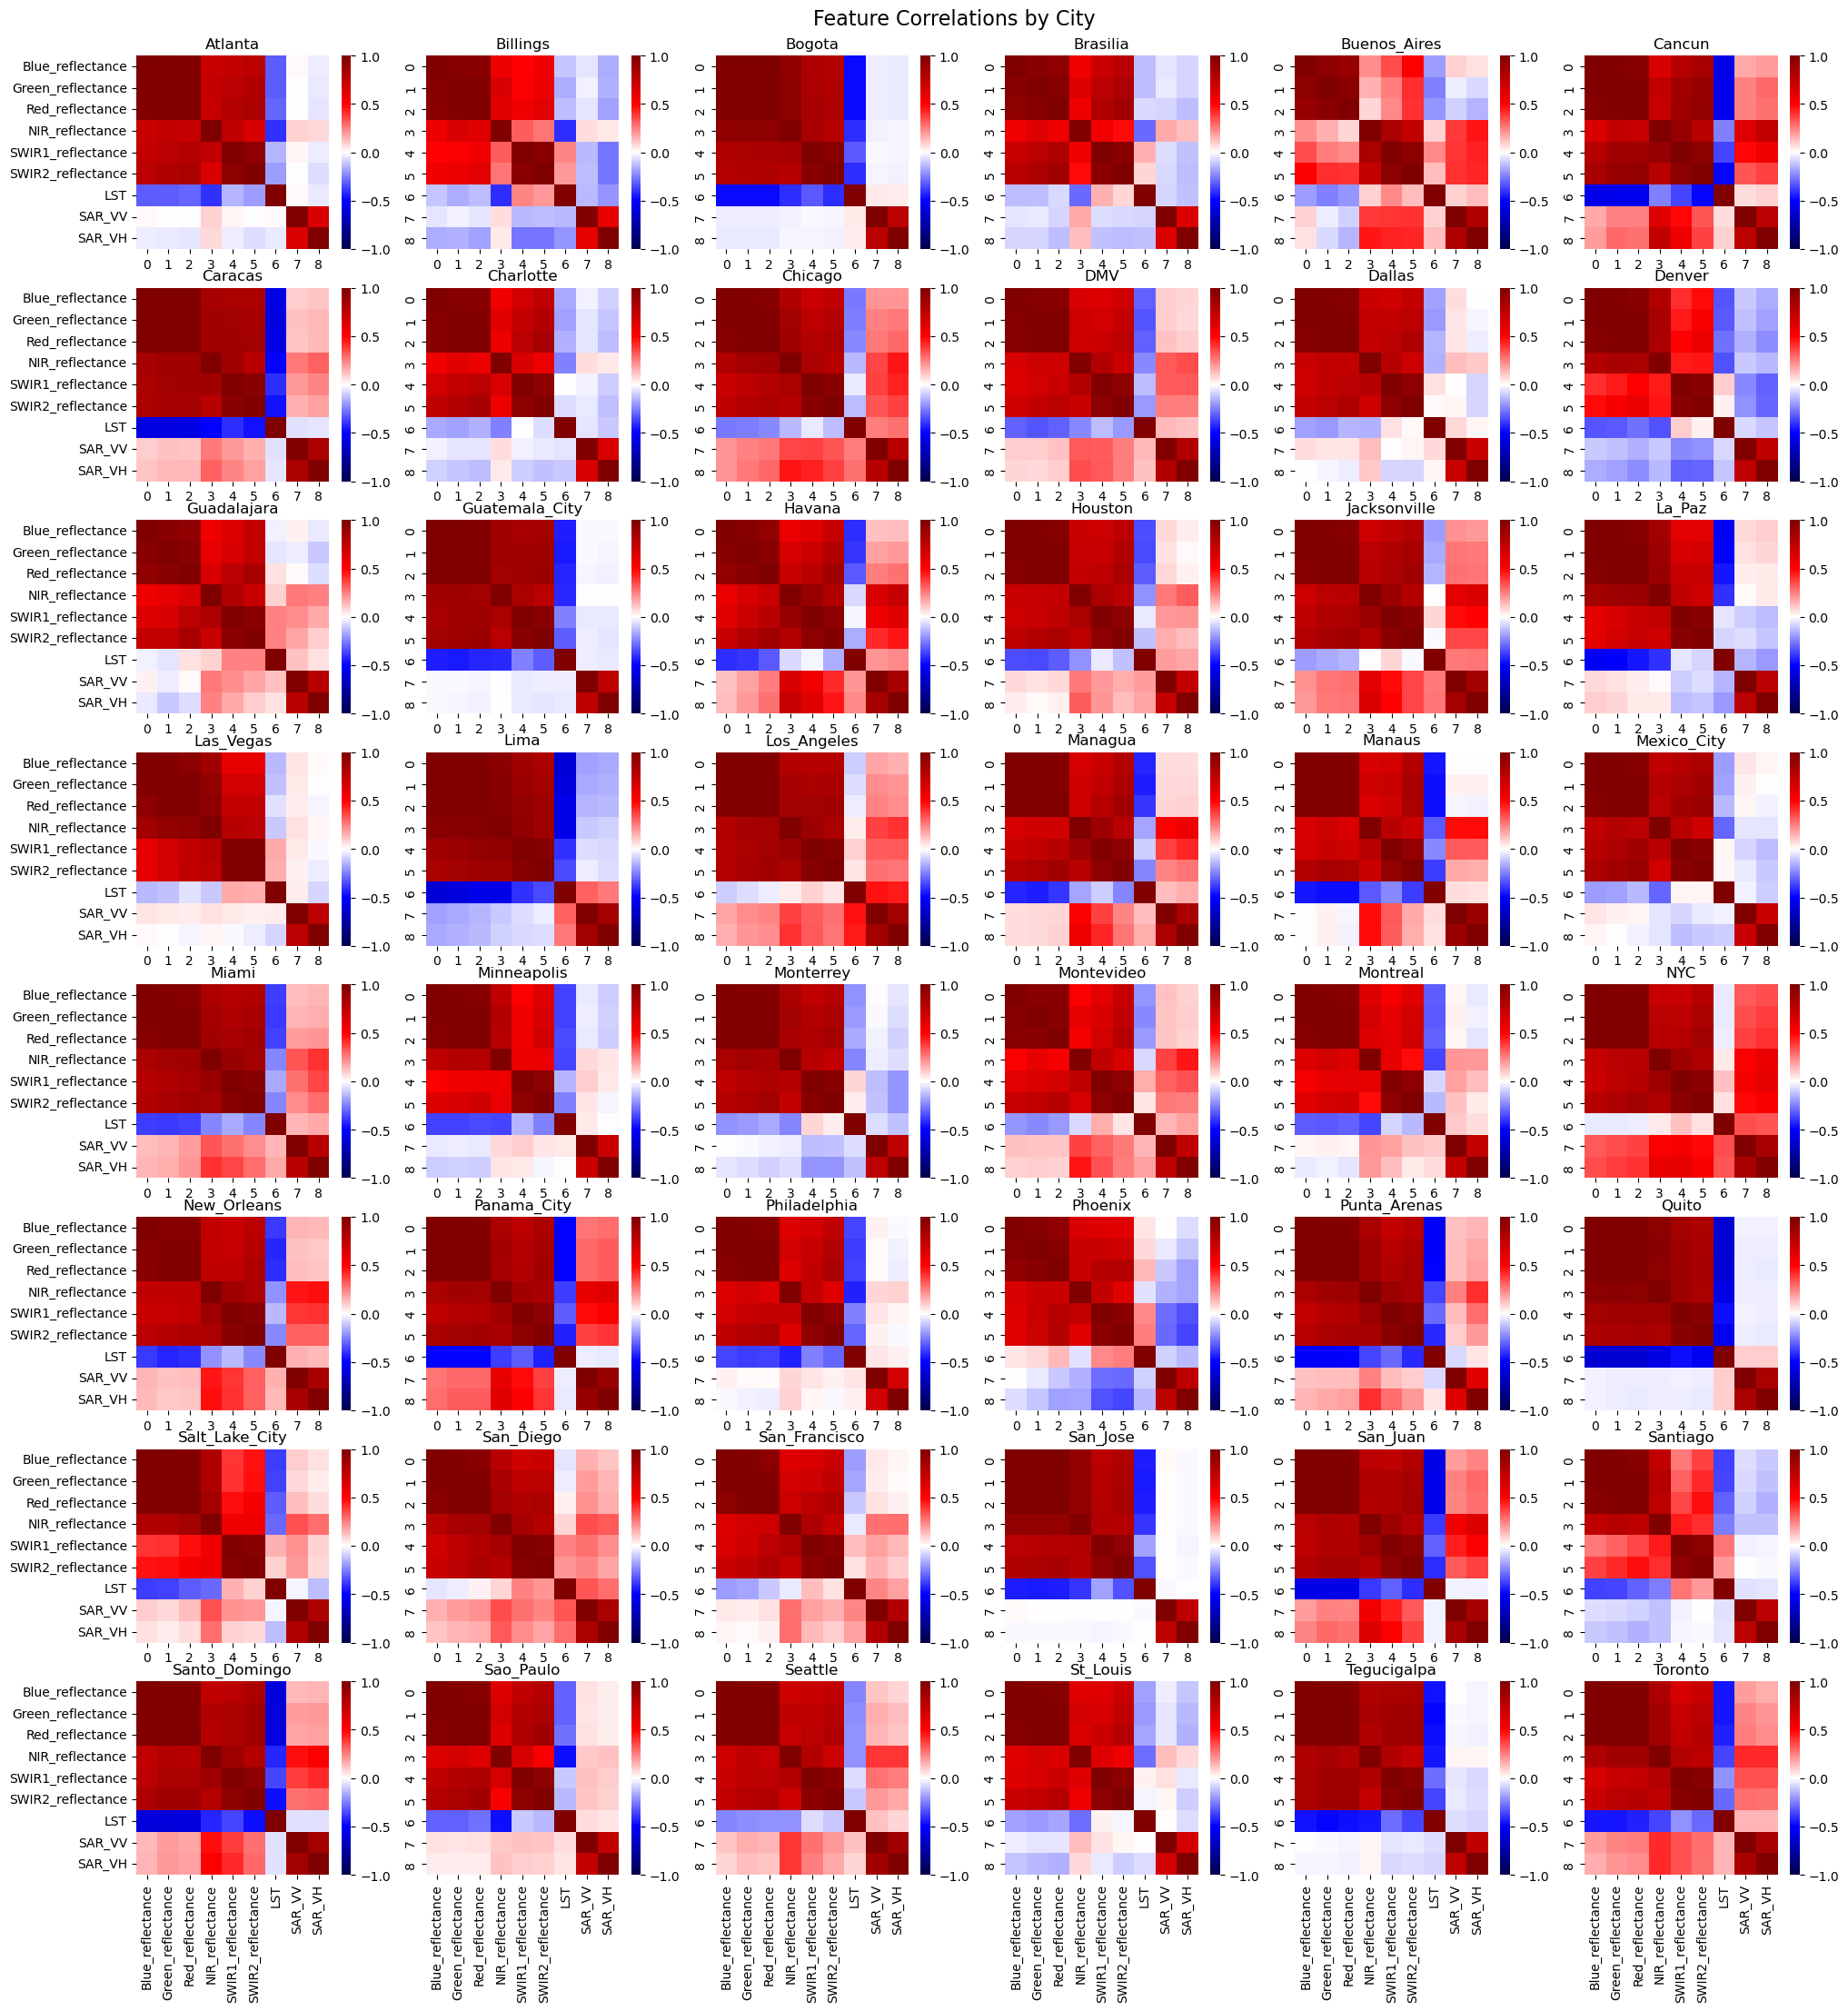

In [12]:
fig, axs = plt.subplots(8, 6)
fig.set_size_inches(24, 26)
#plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.subplots_adjust(hspace=0.2)

for i in range(8):
    for j in range(6):
        city = cities[i*6+j]
        with open(f'/glade/derecho/scratch/jstarfeldt/data_analysis/corr_matrices/{city}_corr_matrix.pkl', 'rb') as file:
            corr_matrix = pickle.load(file)
        if j == 0 and i == 7: # Label y axis for first plot of each row
            sns.heatmap(corr_matrix, xticklabels=vars, yticklabels=vars, annot=False, cmap='seismic', vmin=-1, vmax=1, ax=axs[i,j])
        elif i == 7: # Label x axis for last plot of each column
            sns.heatmap(corr_matrix, xticklabels=vars, annot=False, cmap='seismic', vmin=-1, vmax=1, ax=axs[i,j])
        elif j == 0:
            sns.heatmap(corr_matrix, yticklabels=vars, annot=False, cmap='seismic', vmin=-1, vmax=1, ax=axs[i,j])
        else:
            sns.heatmap(corr_matrix, annot=False, cmap='seismic', vmin=-1, vmax=1, ax=axs[i,j])
        axs[i,j].set_title(city)
plt.suptitle('Feature Correlations by City', y=0.9, fontsize=16)
fig.savefig('/glade/derecho/scratch/jstarfeldt/data_analysis/plots/city_feature_correlations.svg', transparent=True, bbox_inches='tight')

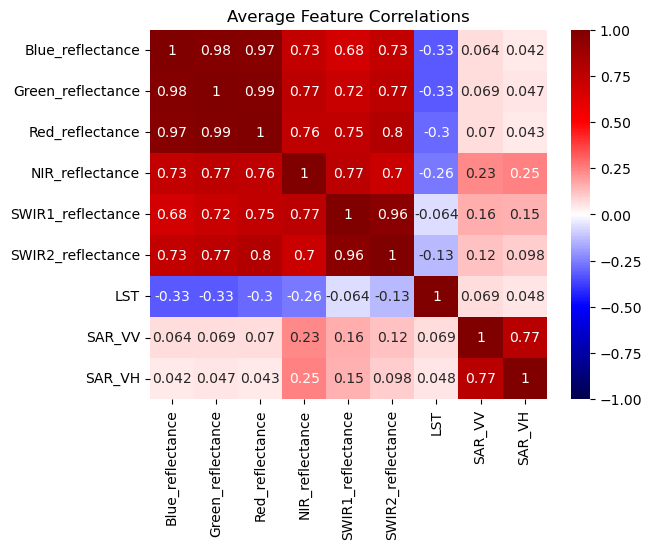

In [13]:
corr_matrices = []

for i in range(8):
    for j in range(6):
        city = cities[i*6+j]
        with open(f'/glade/derecho/scratch/jstarfeldt/data_analysis/corr_matrices/{city}_corr_matrix.pkl', 'rb') as file:
            corr_matrix = pickle.load(file)
            corr_matrices.append(corr_matrix)

sns.heatmap(np.nanmean(np.stack(corr_matrices), axis=0), xticklabels=vars, yticklabels=vars, annot=True, cmap='seismic', vmin=-1, vmax=1)
plt.title('Average Feature Correlations')
plt.savefig('/glade/derecho/scratch/jstarfeldt/data_analysis/plots/average_feature_correlations.svg', transparent=True, bbox_inches='tight')

## Spatial Variability

In [23]:
var_dict = {}

for city in cities:
    LST_vars = []
    city_list = sorted(glob.glob(f'{dataset_root}/{city}/processed_Landsat/*'))
    
    for file in city_list:
        arr = xr.open_dataset(file)['Landsat_LST'].values
        LST_vars.append(np.nanstd(arr))
        
    var_dict[city] = LST_vars

with open(f'/glade/derecho/scratch/jstarfeldt/data_analysis/LST_spatial_stds.pkl', 'wb') as file:
    pickle.dump(var_dict, file)

In [40]:
with open(f'/glade/derecho/scratch/jstarfeldt/data_analysis/LST_spatial_stds.pkl', 'rb') as file:
    var_dict = pickle.load(file)

In [41]:
def get_GOES_temp_variability(city, season_code):
    if season_code == 'DJF':
        months = [12, 1, 2]
    elif season_code == 'MAM':
        months = [3, 4, 5]
    elif season_code == 'JJA':
        months = [6, 7, 8]
    else:
        months = [9, 10, 11]
        
    GOES_var_data = []
    for dt in GOES_date_dict[city]:
        if dt.month in months:
            dt_str = dt.strftime("%Y%m%d%H%M")
            if dt.year == 2022 and dt.month <= 6:
                data = rxr.open_rasterio(f'{dataset_root}/{city}/GOES_2022_1/GOES_image_{dt_str}.tif')
            elif dt.year == 2022 and dt.month > 6:
                data = rxr.open_rasterio(f'{dataset_root}/{city}/GOES_2022_2/GOES_image_{dt_str}.tif')
            elif dt.year == 2023 and dt.month <= 6:
                data = rxr.open_rasterio(f'{dataset_root}/{city}/GOES_2023_1/GOES_image_{dt_str}.tif')
            else:
                data = rxr.open_rasterio(f'{dataset_root}/{city}/GOES_2023_2/GOES_image_{dt_str}.tif')
            GOES_var_data.append(np.mean(np.nanstd(np.reshape(data.values, (4, -1)), axis=1)))
    GOES_data = np.stack(GOES_var_data)
    return GOES_data

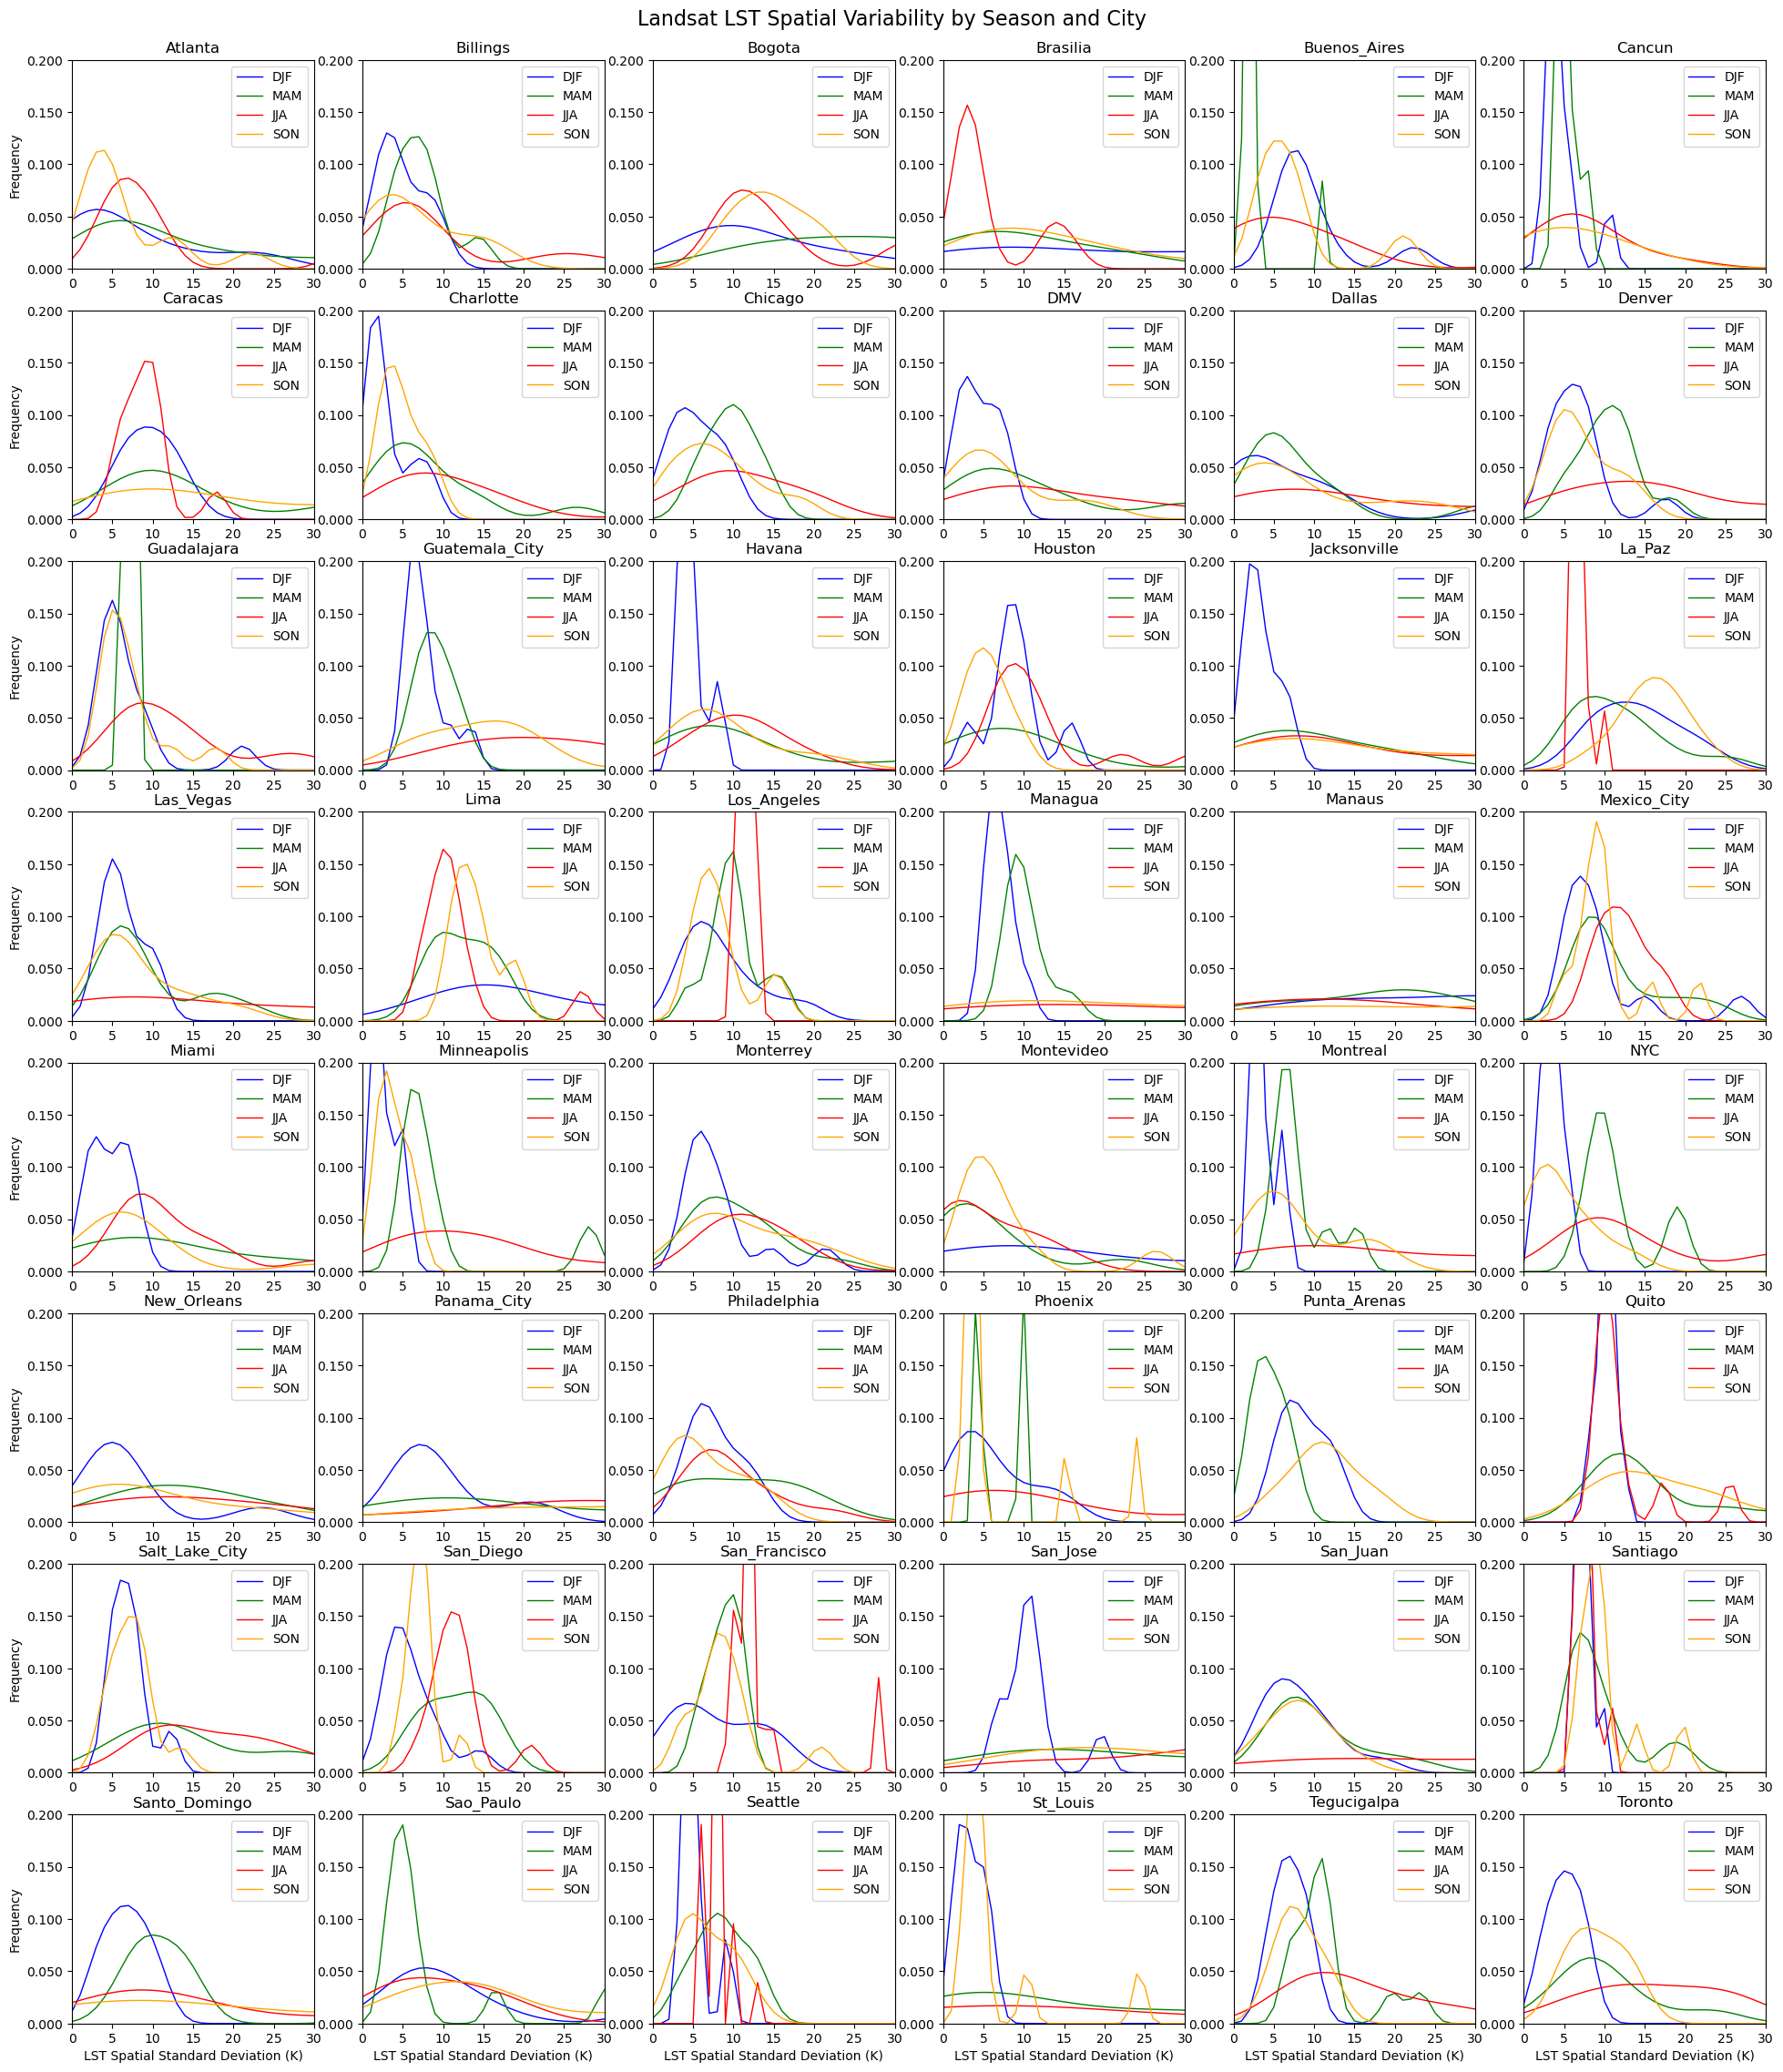

In [43]:
fig, axs = plt.subplots(8, 6)
fig.set_size_inches(24, 28)
#plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.subplots_adjust(hspace=0.2)
x = np.arange(0, 31)

for i in range(8):
    for j in range(6):
        city = cities[i*6+j]
        month_list = np.array([dt.month for dt in date_dict[city]])
        var_list = np.array(var_dict[city])


        DJF_vars = var_list[np.where(np.logical_or(month_list==12, month_list<3))]
        MAM_vars = var_list[np.where(np.logical_and(month_list>=3, month_list<6))]
        JJA_vars = var_list[np.where(np.logical_and(month_list>=6, month_list<9))]
        SON_vars = var_list[np.where(np.logical_and(month_list>=9, month_list<12))]
        DJF_pdf = KDEUnivariate(DJF_vars)
        DJF_pdf.fit()
        MAM_pdf = KDEUnivariate(MAM_vars)
        MAM_pdf.fit()
        JJA_pdf = KDEUnivariate(JJA_vars)
        JJA_pdf.fit()
        SON_pdf = KDEUnivariate(SON_vars)
        SON_pdf.fit()

        axs[i, j].plot(x, DJF_pdf.evaluate(x), color='b', linewidth=1, label='DJF')
        axs[i, j].plot(x, MAM_pdf.evaluate(x), color='g', linewidth=1, label='MAM')
        axs[i, j].plot(x, JJA_pdf.evaluate(x), color='r', linewidth=1, label='JJA')
        axs[i, j].plot(x, SON_pdf.evaluate(x), color='orange', linewidth=1, label='SON')
        axs[i, j].legend()
        axs[i, j].set_title(city)

        # Format y-axis ticks to 3 decimal places
        formatter_y = mticker.StrMethodFormatter("{x:.3f}")
        axs[i, j].yaxis.set_major_formatter(formatter_y)
        axs[i, j].set_xlim(left=0, right=30)
        axs[i, j].set_xticks(np.arange(0, 31, 5))
        axs[i, j].set_ylim(bottom=0, top=0.2)
        axs[i, j].set_yticks(np.arange(0, 0.21, 0.05))

        if j == 0:
            axs[i, j].set_ylabel('Frequency')
        if i == 7:
            axs[i, j].set_xlabel('LST Spatial Standard Deviation (K)')
plt.suptitle('Landsat LST Spatial Variability by Season and City', y=0.9, fontsize=16)
fig.savefig('/glade/derecho/scratch/jstarfeldt/data_analysis/plots/LST_spatial_variability_seasonal_variation.svg', transparent=True, bbox_inches='tight')

0
1
2
3
4
5


/glade/u/home/jstarfeldt/.conda/envs/heat/lib/python3.13/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/u/home/jstarfeldt/.conda/envs/heat/lib/python3.13/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/glade/u/home/jstarfeldt/.conda/envs/heat/lib/python3.13/site-packages/statsmodels/nonparametric/kde.py:593: RuntimeWarning: invalid value encountered in cast
  binned = fast_linbin(x, a, b, gridsize) / (delta * nobs)


6
7


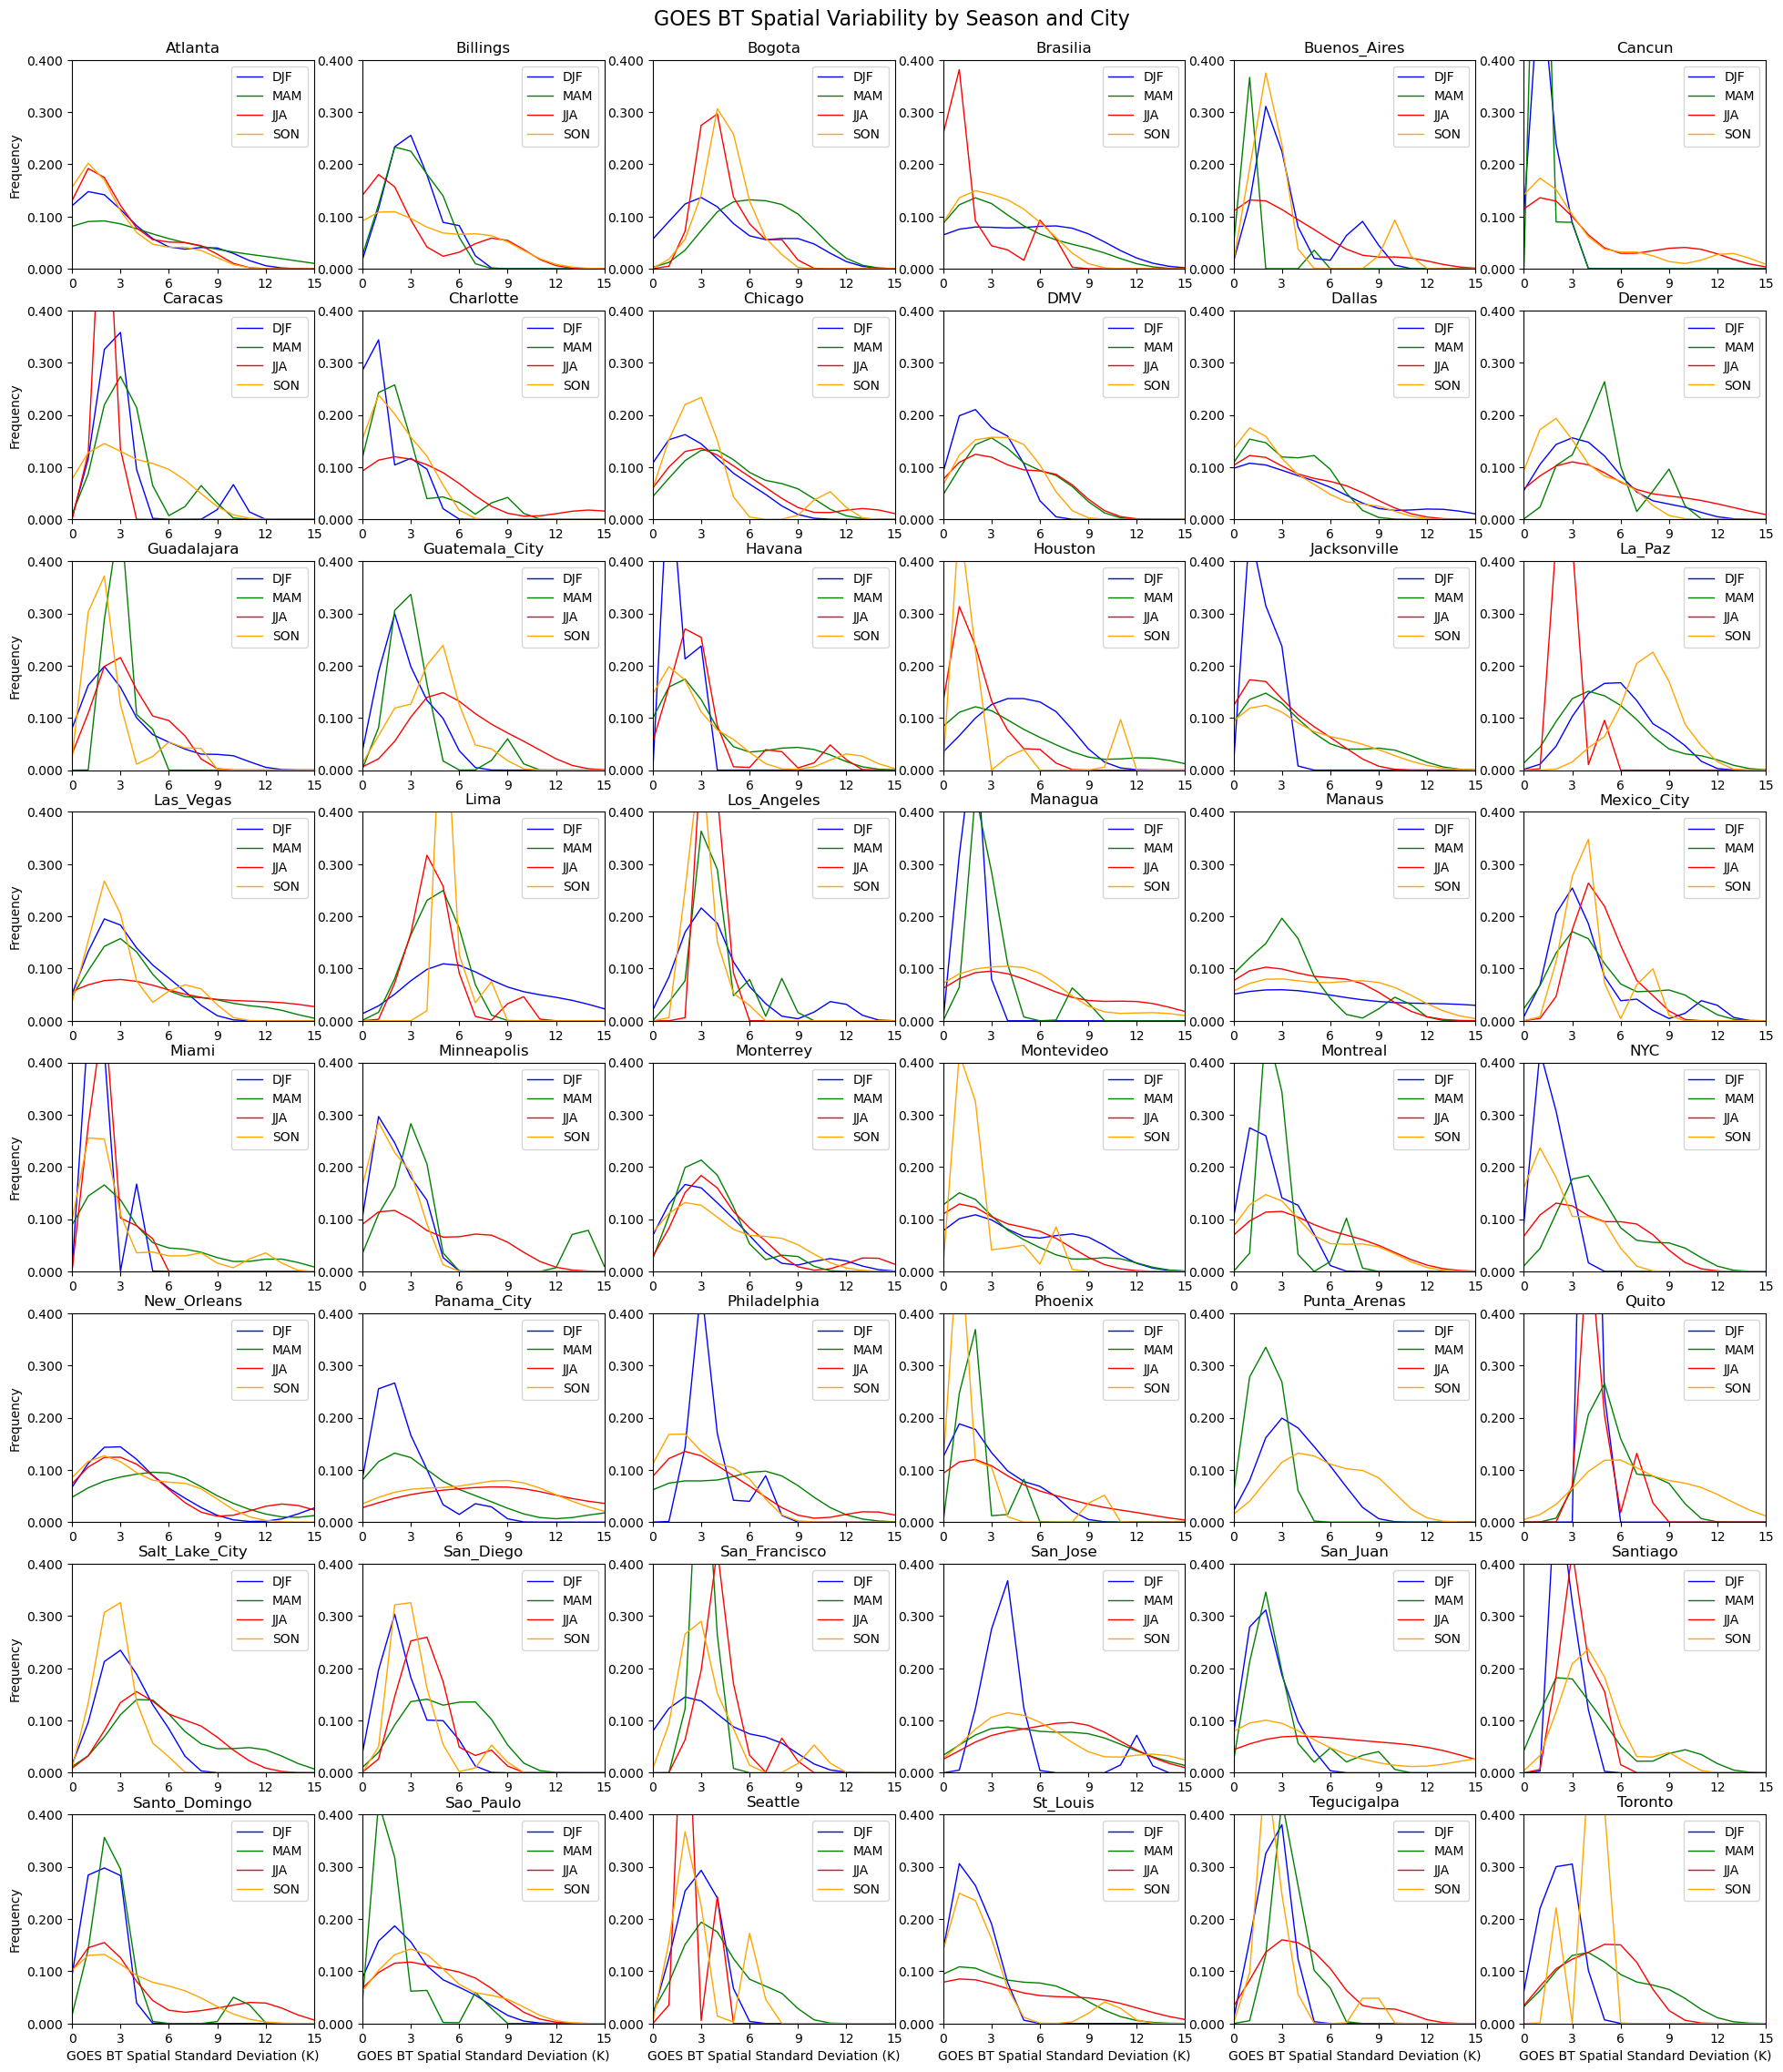

In [44]:
fig, axs = plt.subplots(8, 6)
fig.set_size_inches(24, 28)
#plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.subplots_adjust(hspace=0.2)
x = np.arange(0, 16)

for i in range(8):
    print(i)
    for j in range(6):
        city = cities[i*6+j]

        data = get_GOES_temp_variability(city, 'DJF')
        DJF_pdf = KDEUnivariate(data)
        DJF_pdf.fit()

        data = get_GOES_temp_variability(city, 'MAM')
        MAM_pdf = KDEUnivariate(data)
        MAM_pdf.fit()

        data = get_GOES_temp_variability(city, 'JJA')
        JJA_pdf = KDEUnivariate(data)
        JJA_pdf.fit()

        data = get_GOES_temp_variability(city, 'SON')
        SON_pdf = KDEUnivariate(data)
        SON_pdf.fit()

        axs[i, j].plot(x, DJF_pdf.evaluate(x), color='b', linewidth=1, label='DJF')
        axs[i, j].plot(x, MAM_pdf.evaluate(x), color='g', linewidth=1, label='MAM')
        axs[i, j].plot(x, JJA_pdf.evaluate(x), color='r', linewidth=1, label='JJA')
        axs[i, j].plot(x, SON_pdf.evaluate(x), color='orange', linewidth=1, label='SON')
        axs[i, j].legend()
        axs[i, j].set_title(city)

        # Format y-axis ticks to 3 decimal places
        formatter_y = mticker.StrMethodFormatter("{x:.3f}")
        axs[i, j].yaxis.set_major_formatter(formatter_y)
        axs[i, j].set_xlim(left=0, right=15)
        axs[i, j].set_xticks(np.arange(0, 16, 3))
        axs[i, j].set_ylim(bottom=0, top=0.4)
        axs[i, j].set_yticks(np.arange(0, 0.41, 0.1))

        if j == 0:
            axs[i, j].set_ylabel('Frequency')
        if i == 7:
            axs[i, j].set_xlabel('GOES BT Spatial Standard Deviation (K)')
plt.suptitle('GOES BT Spatial Variability by Season and City', y=0.9, fontsize=16)
fig.savefig('/glade/derecho/scratch/jstarfeldt/data_analysis/plots/GOES_BT_spatial_variability_seasonal_variation.svg', transparent=True, bbox_inches='tight')

## Filtered Landsat vs GOES

In [8]:
from scipy.ndimage import gaussian_filter
from scipy import ndimage
from PIL import Image

In [9]:
def get_GOES_vars(city):
    GOES_var_dict = []
    
    for dt in GOES_date_dict[city]:
        dt_str = dt.strftime("%Y%m%d%H%M")
        if dt.year == 2022 and dt.month <= 6:
            data = rxr.open_rasterio(f'{dataset_root}/{city}/GOES_2022_1/GOES_image_{dt_str}.tif')
        elif dt.year == 2022 and dt.month > 6:
            data = rxr.open_rasterio(f'{dataset_root}/{city}/GOES_2022_2/GOES_image_{dt_str}.tif')
        elif dt.year == 2023 and dt.month <= 6:
            data = rxr.open_rasterio(f'{dataset_root}/{city}/GOES_2023_1/GOES_image_{dt_str}.tif')
        else:
            data = rxr.open_rasterio(f'{dataset_root}/{city}/GOES_2023_2/GOES_image_{dt_str}.tif')      
        GOES_var_dict.append(np.nanstd(data.values.reshape(4,-1), axis=1))

    return GOES_var_dict

In [10]:
def get_filtered_Landsat_vars(city):
    Landsat_var_dict = []
    city_list = sorted(glob.glob(f'{dataset_root}/{city}/processed_Landsat/*'))

    for file in city_list:
        ds = xr.open_dataset(file)
        filtered = gaussian_filter(ds['Landsat_LST'].values, sigma=3)
        resized = np.array(Image.fromarray(filtered).resize((45,45)))
        Landsat_var_dict.append(np.nanstd(resized))
    return Landsat_var_dict

0


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

1


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

2


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

3


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

4
5
6
7


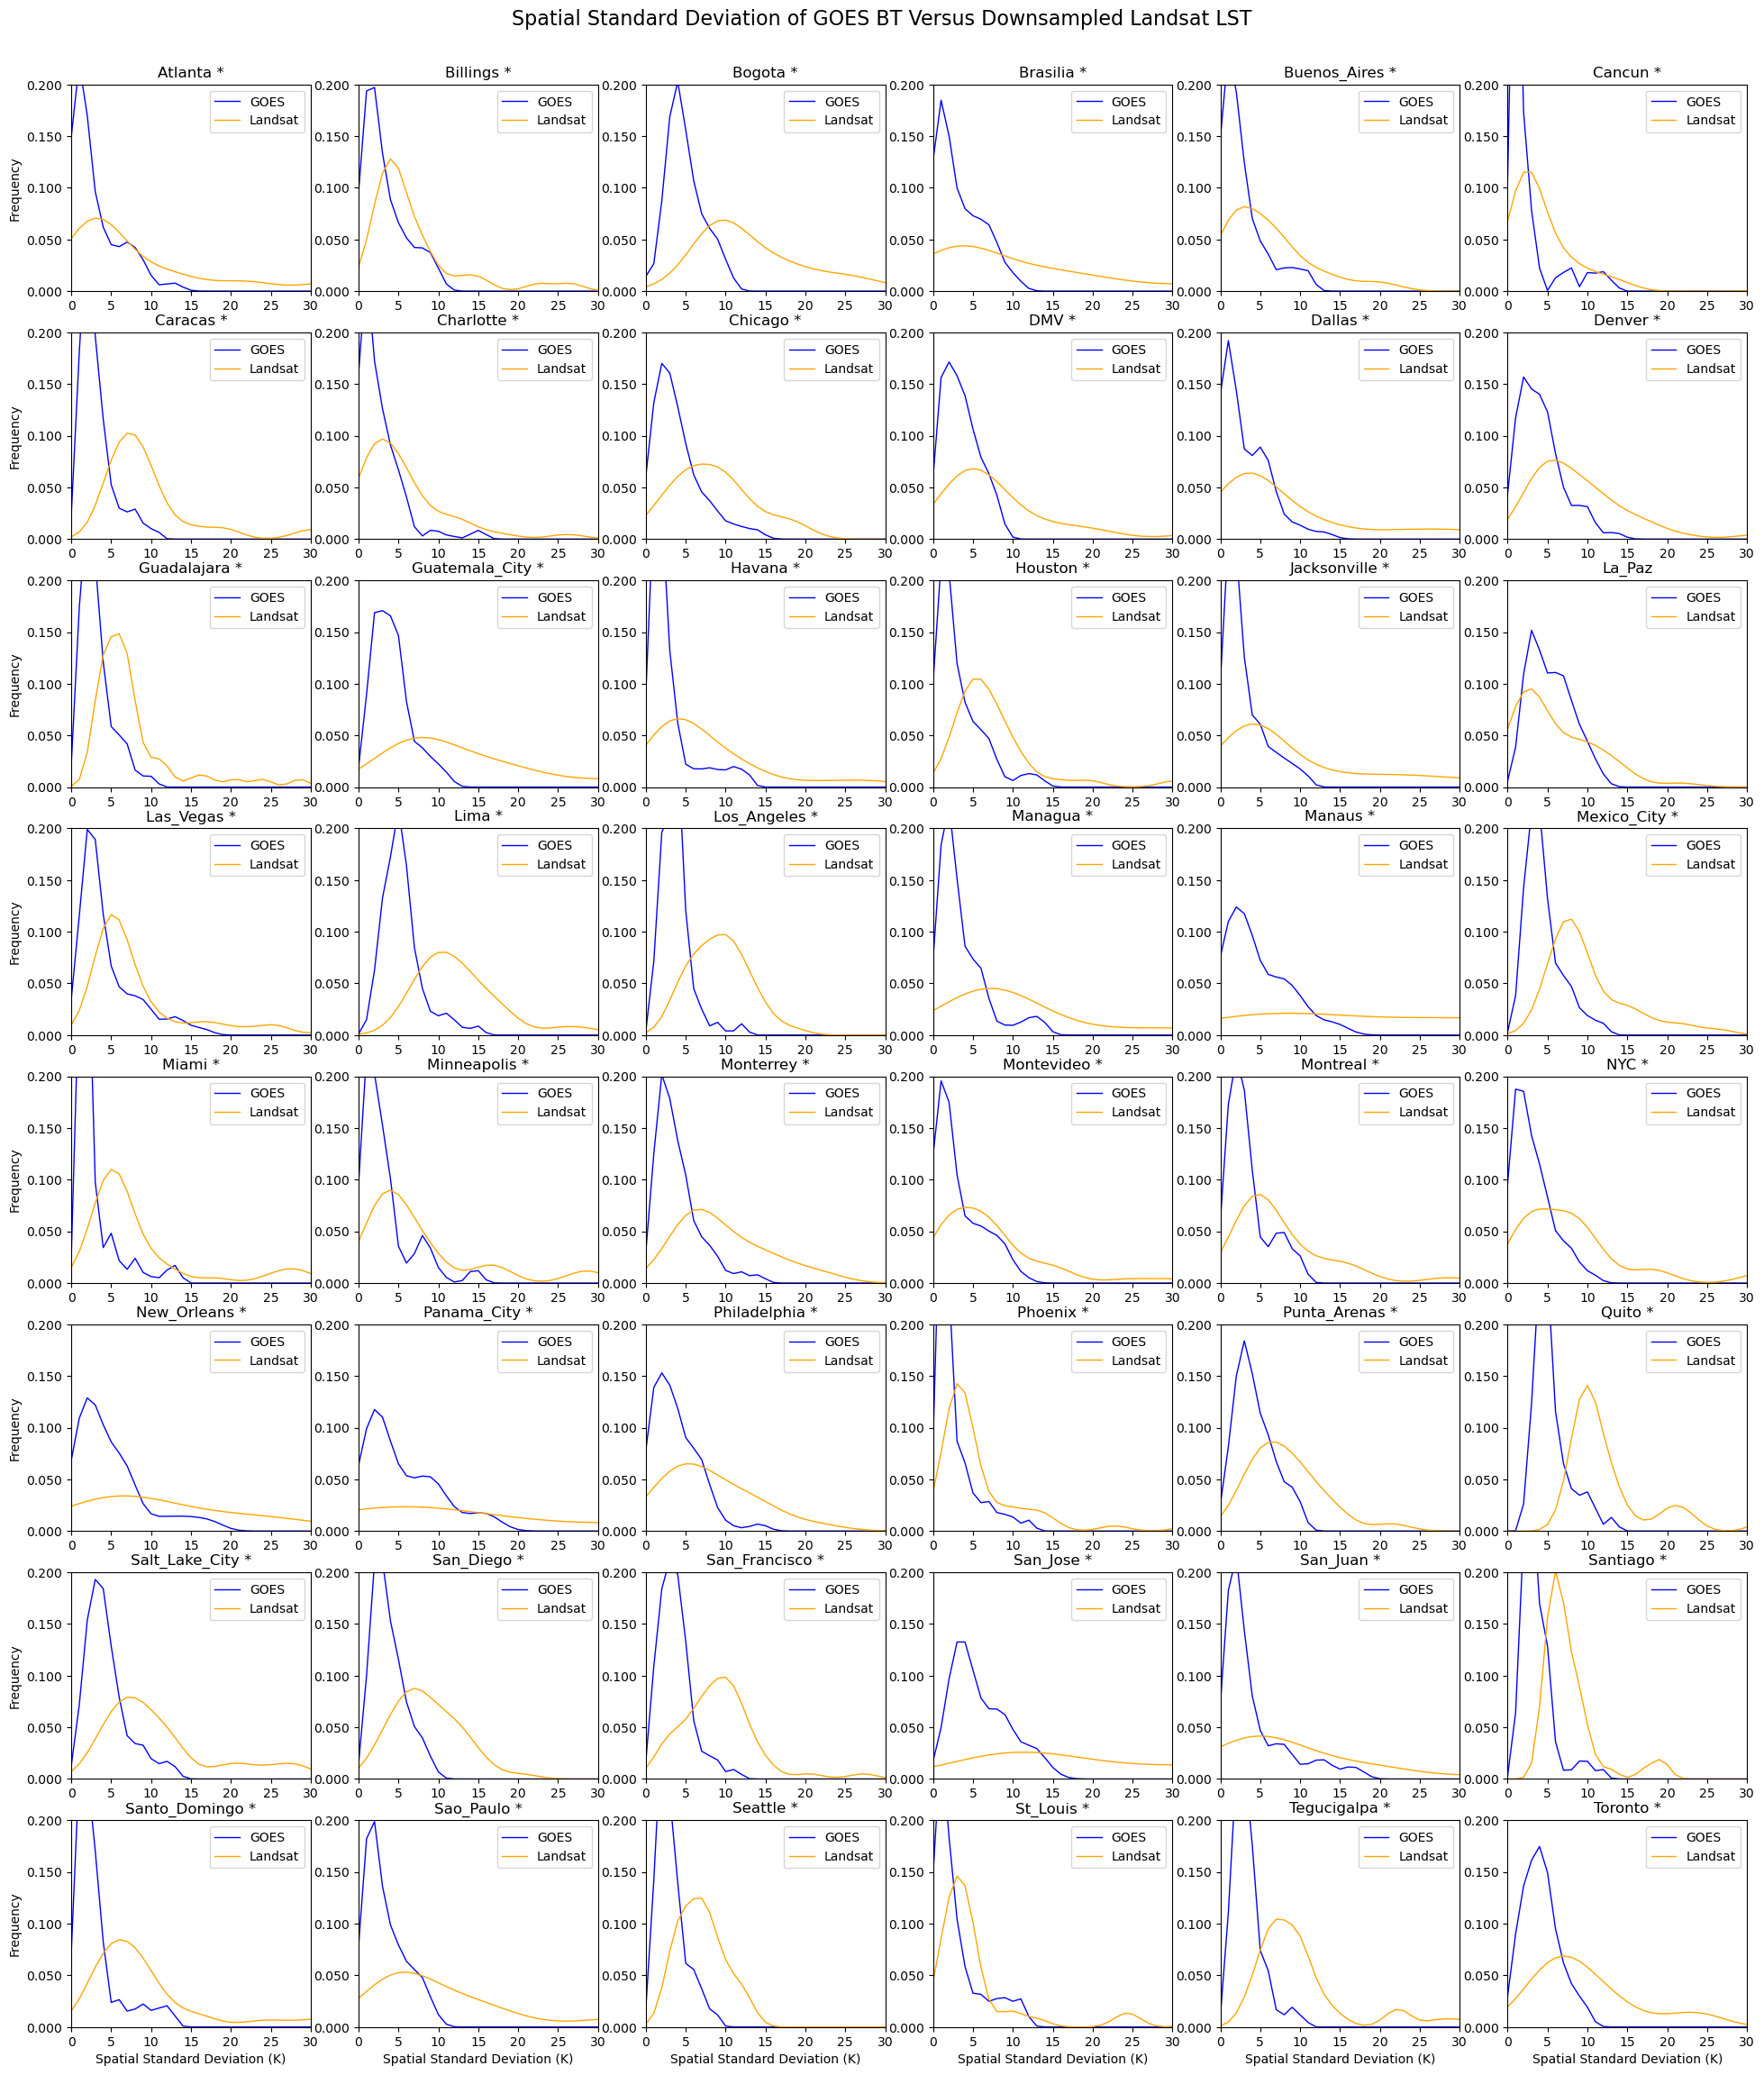

In [12]:
fig, axs = plt.subplots(8, 6)
fig.set_size_inches(24, 28)
#plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.subplots_adjust(hspace=0.2)
p_stats = np.zeros(len(cities))
x = np.arange(0, 31)

for i in range(8):
    print(i)
    for j in range(6):
        city = cities[i*6+j]

        GOES_data = np.stack(get_GOES_vars(city)).flatten()
        GOES_pdf = KDEUnivariate(GOES_data)
        GOES_pdf.fit()

        Landsat_data = np.array(get_filtered_Landsat_vars(city))
        Landsat_pdf = KDEUnivariate(Landsat_data)
        Landsat_pdf.fit()

        # Calculate Mann-Whitney test for equivalence of distribution
        p_value = stats.mannwhitneyu(Landsat_data, GOES_data, nan_policy='omit').pvalue
        p_stats[i] = p_value

        axs[i, j].plot(x, GOES_pdf.evaluate(x), color='b', linewidth=1, label='GOES')
        axs[i, j].plot(x, Landsat_pdf.evaluate(x), color='orange', linewidth=1, label='Landsat')
        axs[i, j].legend()
        if p_value < 0.05:
            axs[i, j].set_title(city+' *')
        else:
            axs[i, j].set_title(city)

        # Format y-axis ticks to 3 decimal places
        formatter_y = mticker.StrMethodFormatter("{x:.3f}")
        axs[i, j].yaxis.set_major_formatter(formatter_y)
        axs[i, j].set_xlim(left=0, right=30)
        axs[i, j].set_xticks(np.arange(0, 31, 5))
        axs[i, j].set_ylim(bottom=0, top=0.2)
        axs[i, j].set_yticks(np.arange(0, 0.21, 0.05))

        if j == 0:
            axs[i, j].set_ylabel('Frequency')
        if i == 7:
            axs[i, j].set_xlabel('Spatial Standard Deviation (K)')
plt.suptitle('Spatial Standard Deviation of GOES BT Versus Downsampled Landsat LST', y=0.91, fontsize=16)
fig.savefig('/glade/derecho/scratch/jstarfeldt/data_analysis/plots/Filtered_spatial_variabilities.svg', transparent=True, bbox_inches='tight')